In [1]:
# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
%matplotlib inline

# импортируем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split


# импортируем библиотеки, необходимы для работы с математическими и регулярными выражениями
import math
import re

# импортируем другие необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn import preprocessing #
import category_encoders as ce # импорт для работы с кодировщиком # кодирование OneHot
from sklearn import utils
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer # оценка слов на позитивное или негативое настроение

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [5]:
# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## 1. Исследование данных

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   

                        hotel_name reviewer_nationality  negative_review  \
0               The May Fair Hotel      United Kingdom          Leaving    
1  Mercure London Bloomsbury Hotel      United Kingdom    poor breakfast   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                  3                     1994   
1                                  3                     1361   

       positive_review  review_total_positive_word_counts  \
0   Staff were amazing                                  4   
1             location                                  2   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097

In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443

In [10]:
sample_submission.head(2)

reviewer_score      id
0               1  488440
1              10  274649

In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [14]:
data.nunique()

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1472
lng                                             1472
sample                                             2
reviewer_score                                    38
dtype: int64

In [15]:
data.head(2)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

   additional_number_of_scoring review_date  average_score         hotel_name  \
0                           904   7/21/2017            8.1     Hotel Da Vinci   
1                           612  12/12/2016            8.6  Urban Lodge Hotel   

  reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0             0.0  
1  52.385649  4.834443       0             0.0

In [16]:
data.describe()

additional_number_of_scoring  average_score  \
count                 515738.000000  515738.000000   
mean                     498.081836       8.397487   
std                      500.538467       0.548048   
min                        1.000000       5.200000   
25%                      169.000000       8.100000   
50%                      341.000000       8.400000   
75%                      660.000000       8.800000   
max                     2682.000000       9.800000   

       review_total_negative_word_counts  total_number_of_reviews  \
count                      515738.000000            515738.000000   
mean                           18.539450              2743.743944   
std                            29.690831              2317.464868   
min                             0.000000                43.000000   
25%                             2.000000              1161.000000   
50%                             9.000000              2134.000000   
75%                            23.000000              3613.000000   
max                           408.000000             16670.000000   

       review_total_positive_word_counts  \
count                      515738.000000   
mean                           17.776458   
std                            21.804185   
min                             0.000000   
25%                             5.000000   
50%                            11.000000   
75%                            22.000000   
max                           395.000000   

       total_number_of_reviews_reviewer_has_given            lat  \
count                               515738.000000  512470.000000   
mean                                     7.166001      49.442439   
std                                     11.040228       3.466325   
min                                      1.000000      41.328376   
25%                                      1.000000      48.214662   
50%                                      3.000000      51.499981   
75%                                      8.000000      51.516288   
max                                    355.000000      52.400181   

                 lng         sample  reviewer_score  
count  512470.000000  515738.000000   515738.000000  
mean        2.823803       0.749999        6.297672  
std         4.579425       0.433014        3.902295  
min        -0.369758       0.000000        0.000000  
25%        -0.143372       0.250000        0.625000  
50%         0.010607       1.000000        7.900000  
75%         4.834443       1.000000        9.600000  
max        16.429233       1.000000       10.000000

In [17]:
data.describe(include='object')

hotel_address review_date  \
count                                              515738      515738   
unique                                               1493         731   
top     163 Marsh Wall Docklands Tower Hamlets London ...    8/2/2017   
freq                                                 4789        2585   

                                        hotel_name reviewer_nationality  \
count                                       515738               515738   
unique                                        1492                  227   
top     Britannia International Hotel Canary Wharf      United Kingdom    
freq                                          4789               245246   

       negative_review positive_review  \
count           515738          515738   
unique          330011          412601   
top        No Negative     No Positive   
freq            127890           35946   

                                                     tags days_since_review  
count                                              515738            515738  
unique                                              55242               731  
top     [' Leisure trip ', ' Couple ', ' Double Room '...            1 days  
freq                                                 5101              2585

#### Проведем небольшое исследование зависимости целевого признака reviewer_score от числовых признаков.

In [18]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
del num_features[8:10] #удалим неинформативные признаки из списка
num_features

['additional_number_of_scoring',
 'average_score',
 'review_total_negative_word_counts',
 'total_number_of_reviews',
 'review_total_positive_word_counts',
 'total_number_of_reviews_reviewer_has_given',
 'lat',
 'lng']

Для каждого числового признака построим гистограмму признаки и диаграмму рассеяния, иллюстрирующую зависимость целевого признака от каждого из факторов. Дополнительно поверх диаграммы рассеяния построим уравнение линейной регрессии. 

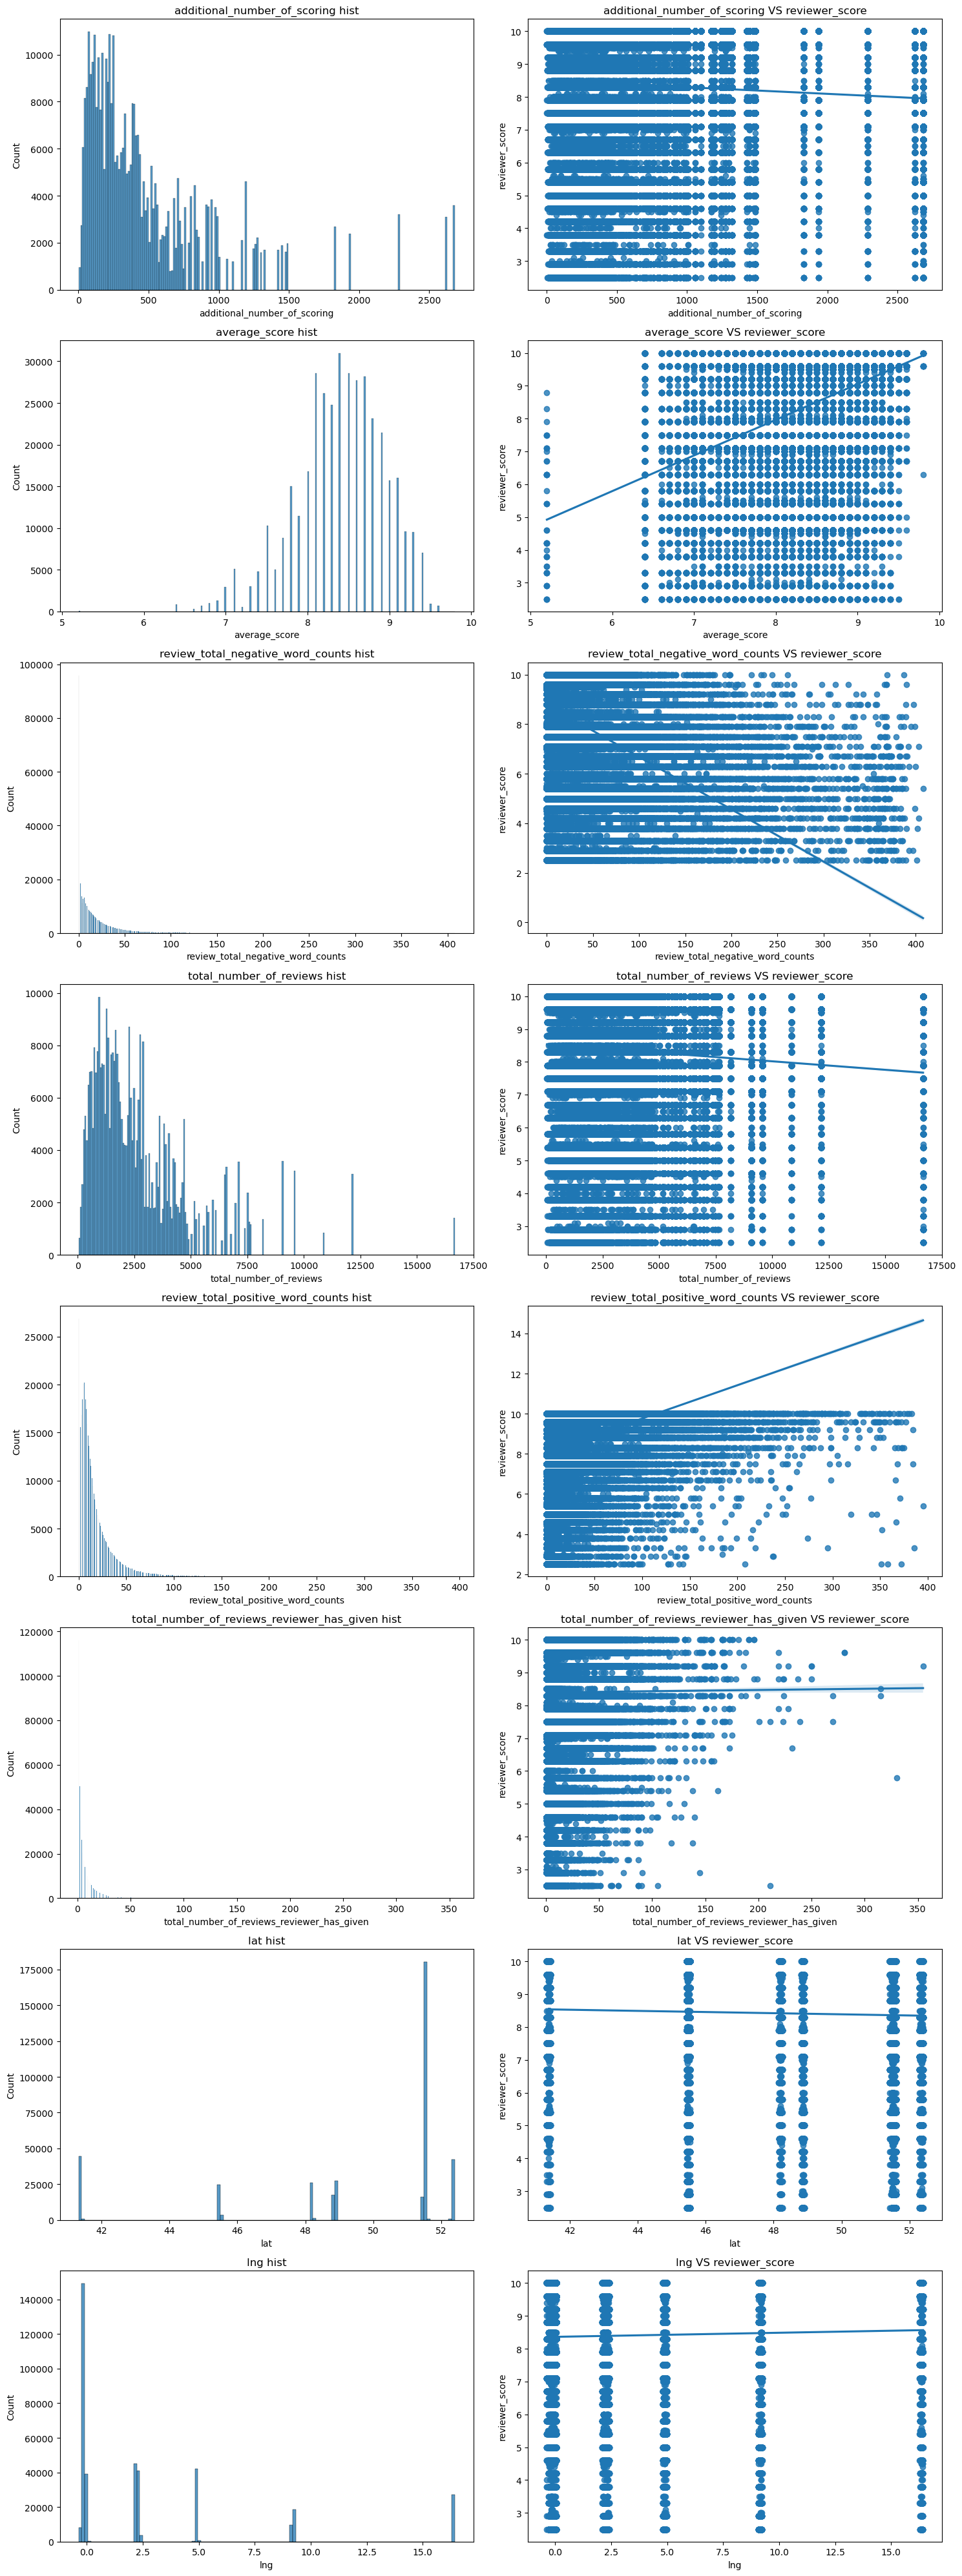

In [19]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data[data['sample']==1], x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data[data['sample']==1], x=feature, y='reviewer_score', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS reviewer_score'.format(feature));
plt.tight_layout() #выравнивание графиков

Здесь мое особое внимание привлекли три признака:  

'average_score'- здесь понятно, что зависимость от целевого признака практически прямая, поэтому будем использовать это признак для целей подготовки данных.

'review_total_negative_word_counts' и 'review_total_positive_word_counts' - а вот здесь также есть сильная зависимость от целевого признака, но почему - остается только размышлять, ну и применять данный факт для решения нашей задачи. Получается, что чем больше слов в негативной рецензии - тем ниже оценка (есть много негативных эмоций и соответственно слов), чем меньше - тем выше (если всё в норме, то о чем говорить?), и наоборот, для положительных отзывов - меньше слов - оценка ниже (нечего сказать положительного), много слов - высокая оценка (положительных эмоций много - можно и нахвалить множеством хороших слов)

<AxesSubplot:>

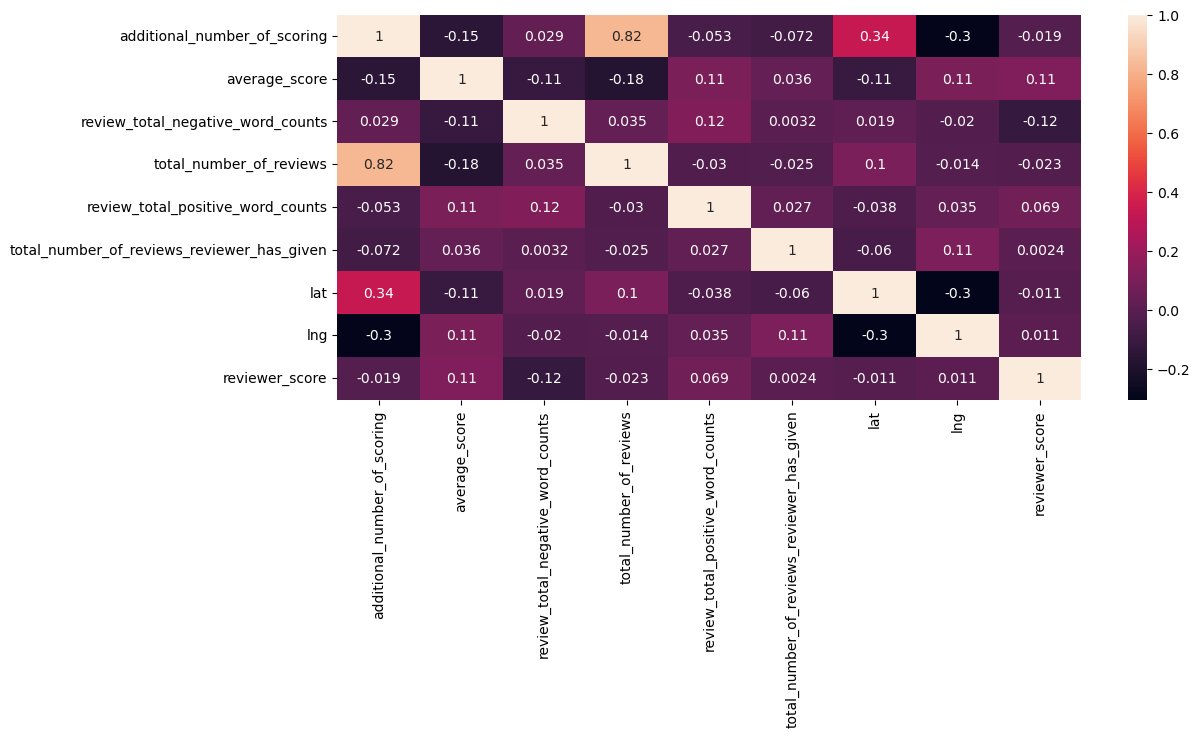

In [20]:
#строим тепловую карту корреляций
plt.rcParams['figure.figsize'] = (12,5)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

Здесь видим сильную корреляцию между 'additional_number_of_scoring' и 'total_number_of_reviews'. Можно будет удалить один из признаков, но позже. Посмотрим как это будет влиять на конечный резулатат

## 2. Подготовка данных

### 2.1 Убираем лишнее, заполняем пропущенное.

В наших данных есть пропуски, избавимся от них.

In [21]:
# посмотрим, как пропуски в 'lat' распределяются по адресам отелей
data[data['lat'].isnull()]['hotel_address'].value_counts()

Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
4 rue de la P pini re 8th arr 75008 Paris France               290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            147
Bail n 4 6 Eixample 08010 Barcelona Spain                      146
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             93
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               61
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        57
23 Rue Damr mont 18th arr 75018 Paris France                    55
Paragonstra e 1 11 Simmering 1110 Vienna Austria                49
20 Rue De La Ga t 14th arr 75014 Paris France                 

In [22]:
# посмотрим, как пропуски в 'lng' распределяются по адресам отелей
data[data['lng'].isnull()]['hotel_address'].value_counts()

Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria    658
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria            563
W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria       389
4 rue de la P pini re 8th arr 75008 Paris France               290
Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria         245
W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria          223
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria               194
Sieveringer Stra e 4 19 D bling 1190 Vienna Austria            147
Bail n 4 6 Eixample 08010 Barcelona Spain                      146
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria             93
Hasenauerstra e 12 19 D bling 1190 Vienna Austria               61
Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria        57
23 Rue Damr mont 18th arr 75018 Paris France                    55
Paragonstra e 1 11 Simmering 1110 Vienna Austria                49
20 Rue De La Ga t 14th arr 75014 Paris France                 

Убеждаемся, что пропуски в 'lat идентичны пропускам в 'lng'. Далее, сначала заполним справочный датафрейм адресов с пустыми значениями широты и долготы, а затем апдейтим этими значениями основной датафрейм

In [23]:
# создадим справочный фрейм для геокоординат отелей (пока с нулями)
df_geo = data[data['lat'].isnull()].groupby('hotel_address').count()[['lat', 'lng']]
df_geo

lat  lng
hotel_address                                               
20 Rue De La Ga t 14th arr 75014 Paris France         0    0
23 Rue Damr mont 18th arr 75018 Paris France          0    0
4 rue de la P pini re 8th arr 75008 Paris France      0    0
Bail n 4 6 Eixample 08010 Barcelona Spain             0    0
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Aus...    0    0
Hasenauerstra e 12 19 D bling 1190 Vienna Austria     0    0
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vi...    0    0
Josefst dter Stra e 22 08 Josefstadt 1080 Vienn...    0    0
Landstra er G rtel 5 03 Landstra e 1030 Vienna ...    0    0
Paragonstra e 1 11 Simmering 1110 Vienna Austria      0    0
Pau Clar s 122 Eixample 08009 Barcelona Spain         0    0
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria      0    0
Sep lveda 180 Eixample 08011 Barcelona Spain          0    0
Sieveringer Stra e 4 19 D bling 1190 Vienna Aus...    0    0
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Aus...    0    0
W hringer Stra e 12 09 Alsergrund 1090 Vienna A...    0    0
W hringer Stra e 33 35 09 Alsergrund 1090 Vienn...    0    0

In [24]:
# напишем список с координатами по каждому из отелей в порядке расположения отелей в справочном фрейме 
# (благо их всего 17 и можно не использовать доп.ресурсы) 

lst_geo = [[48.8399957, 2.3070823], 
           [48.8889127, 2.3309643], 
           [48.8753208, 2.3212033], 
           [41.391552, 2.1757053],
           [48.2208555, 16.3644228],
           [48.233592, 16.3434781],
           [48.2094054, 16.3512565],
           [48.2095525, 16.3492746],
           [48.1888183, 16.381591],
           [48.1868142, 16.418528],
           [41.3749946, 2.1102353],
           [48.219573, 16.2834034],
           [41.3832425, 2.1607609],
           [48.2458909, 16.3397395],
           [48.2135906, 16.3777195],
           [48.2168032, 16.357717],
           [48.220414, 16.3536299]]

In [25]:
# заполним справочный фрейм координатами
for i in range (17):
    df_geo.iloc[i] = lst_geo[i]
df_geo

lat        lng
hotel_address                                                           
20 Rue De La Ga t 14th arr 75014 Paris France       48.839996   2.307082
23 Rue Damr mont 18th arr 75018 Paris France        48.888913   2.330964
4 rue de la P pini re 8th arr 75008 Paris France    48.875321   2.321203
Bail n 4 6 Eixample 08010 Barcelona Spain           41.391552   2.175705
Gr nentorgasse 30 09 Alsergrund 1090 Vienna Aus...  48.220855  16.364423
Hasenauerstra e 12 19 D bling 1190 Vienna Austria   48.233592  16.343478
Josefst dter Stra e 10 12 08 Josefstadt 1080 Vi...  48.209405  16.351257
Josefst dter Stra e 22 08 Josefstadt 1080 Vienn...  48.209553  16.349275
Landstra er G rtel 5 03 Landstra e 1030 Vienna ...  48.188818  16.381591
Paragonstra e 1 11 Simmering 1110 Vienna Austria    48.186814  16.418528
Pau Clar s 122 Eixample 08009 Barcelona Spain       41.374995   2.110235
Savoyenstra e 2 16 Ottakring 1160 Vienna Austria    48.219573  16.283403
Sep lveda 180 Eixample 08011 Barcelona Spain        41.383243   2.160761
Sieveringer Stra e 4 19 D bling 1190 Vienna Aus...  48.245891  16.339740
Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Aus...  48.213591  16.377720
W hringer Stra e 12 09 Alsergrund 1090 Vienna A...  48.216803  16.357717
W hringer Stra e 33 35 09 Alsergrund 1090 Vienn...  48.220414  16.353630

In [26]:
# теперь осталось дополнить координатами  из справочного фрейма наш основной датафрейм
data = data.set_index('hotel_address')
data.update(df_geo)
data = data.reset_index()

In [27]:
# проверяем, что не осталось пустых значений
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [28]:
# проверяем уникальность значений
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             227
negative_review                               330011
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               412601
review_total_positive_word_counts                365
total_number_of_reviews_reviewer_has_given       198
tags                                           55242
days_since_review                                731
lat                                             1489
lng                                             1489
sample                                             2
reviewer_score                                    38
dtype: int64

Видим небольшую разницу между количеством адресов, названий, долготы и широты отелей. Вдаваться в подробности не будем, так как не думаю, что это окажет существенного влияния на решение нашей задачи.


Посмотрим, есть ли дублирующие записи в нашем датафрейме

In [29]:
data[data.duplicated ()]

hotel_address  \
26726   Scarsdale Place Kensington Kensington and Chel...   
49098   40 Rue du Commandant Ren Mouchotte 14th arr 75...   
49541   40 Rue du Commandant Ren Mouchotte 14th arr 75...   
50267   7 rue Casimir Delavigne 6th arr 75006 Paris Fr...   
51878   40 Rue du Commandant Ren Mouchotte 14th arr 75...   
...                                                   ...   
512039  7 rue Casimir Delavigne 6th arr 75006 Paris Fr...   
512118  40 Rue du Commandant Ren Mouchotte 14th arr 75...   
512733  40 Rue du Commandant Ren Mouchotte 14th arr 75...   
513053  40 Rue du Commandant Ren Mouchotte 14th arr 75...   
514376  40 Rue du Commandant Ren Mouchotte 14th arr 75...   

        additional_number_of_scoring review_date  average_score  \
26726                           1831   11/8/2016            8.1   
49098                            228   7/16/2017            7.9   
49541                            228    4/9/2017            7.9   
50267                             44   3/20/2016            9.0   
51878                            228    7/5/2017            7.9   
...                              ...         ...            ...   
512039                            44   11/3/2015            9.0   
512118                           228   7/28/2016            7.9   
512733                           228   5/15/2017            7.9   
513053                           228  10/12/2015            7.9   
514376                           228   8/25/2015            7.9   

                                    hotel_name        reviewer_nationality  \
26726   Copthorne Tara Hotel London Kensington             United Kingdom    
49098              H tel Concorde Montparnasse   United States of America    
49541              H tel Concorde Montparnasse                    Lebanon    
50267                              H tel Baume   United States of America    
51878              H tel Concorde Montparnasse                    Belgium    
...                                        ...                         ...   
512039                             H tel Baume   United States of America    
512118             H tel Concorde Montparnasse                     France    
512733             H tel Concorde Montparnasse             United Kingdom    
513053             H tel Concorde Montparnasse                  Australia    
514376             H tel Concorde Montparnasse                     France    

                                          negative_review  \
26726                                         No Negative   
49098                                         No Negative   
49541                 Elevator needs restoration Cleaning   
50267                                         No Negative   
51878    Absence of a proper fridge what they call min...   
...                                                   ...   
512039                              Rooms are very small    
512118   A bit noisy old fashion At almost 20 the brea...   
512733   twice spoken to staff to replace the coffee w...   
513053   No great restaurants within a short walk but ...   
514376   Rooms not very noise insulated within the bui...   

        review_total_negative_word_counts  total_number_of_reviews  \
26726                                   0                     7105   
49098                                   0                     2515   
49541                                   5                     2515   
50267                                   0                      253   
51878                                  25                     2515   
...                                   ...                      ...   
512039                                  6                      253   
512118                                 18                     2515   
512733                                 24                     2515   
513053                                 12                     2515   
514376                                  9                     2515

Дублирующие записи есть, но странным образом они дублируются не по всем столбцам, поэтому здесь удалять ничего не будем

### 2.2 Разбираем признаки. 

#### 2.2.1 Признак 'hotel_address' (адрес отеля).
Здесь можно выхватить информацию о стране и городе нахождения отеля. Заберем эту инфу себе.

In [30]:
# выделим страну из адреса(hotel_address)
data['hotel_country'] = data['hotel_address'].apply(lambda x: x.split()[-1])
# исправляем название страны Kingdom на United Kingdom
data.loc[data['hotel_country'] == 'Kingdom', 'hotel_country'] = 'United Kingdom'

In [31]:
# выделяем город
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-2])
# находим правильный город в United Kingdom
data.loc[data['hotel_city'] == 'United', 'hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5])

In [32]:
# проверяем, что данные по стране и городу идентичны
data[['hotel_country', 'hotel_city']].value_counts()

hotel_country   hotel_city
United Kingdom  London        262301
Spain           Barcelona      60149
France          Paris          59928
Netherlands     Amsterdam      57214
Austria         Vienna         38939
Italy           Milan          37207
dtype: int64

Всего шесть стран и шесть городов в этих странах. Значит, будем использовать только один признак, например, город расположения отеля. Для дальнейшего использования информации о городе отеля мы кодируем этот признак OneHot кодированием, но позже, когда все задачи по подготовке данных будут решены и определены все признаки для такого кодирования. Тогда мы  используем метод get_dummies для массового кодирования (этот метод создает новые бинарные признаки для каждого значения преобразуемого признака и удаляет этот признак).

#### 2.2.2 Признак 'additional_number_of_scoring' (количество отзывов без оценок).

Здесь пока тяжело что-то сказать, но видя похожесть гистограмм и сильную корреляцию с признаком 'total_number_of_reviews', делаю вывод, что в дальнейшем это признак можно будет удалить... или нет...

In [33]:
data.drop(columns= ['additional_number_of_scoring'], inplace=True)

#### 2.2.3 Признак 'review_date' (дата оставления отзыва).

Здесь мы можем взять информацию о годе, месяце и дне недели оставления резюме. А потом посмотрим вляиние.

In [34]:
# 'review_date' переводим в формат datetime64
data['review_date'] = pd.to_datetime(data['review_date'])

# создаём новые признаки:
# 'день недели'
data['day_of_week'] = data['review_date'].apply(lambda x: x.strftime('%w')).astype('int64')
# 'месяц'
data['month'] = data['review_date'].apply(lambda x: x.strftime('%m')).astype('int64')
# 'год', забегая вперед скажу, что тут три значения года 15, 16, 17, 
# поэтому для удобства дальнейшего использования приведу года к значениям 0, 1, 2, сооответственно 
data['year'] = data['review_date'].apply(lambda x: x.strftime('%y')).astype('int64') - 15

In [35]:
num_features=['day_of_week','month','year']

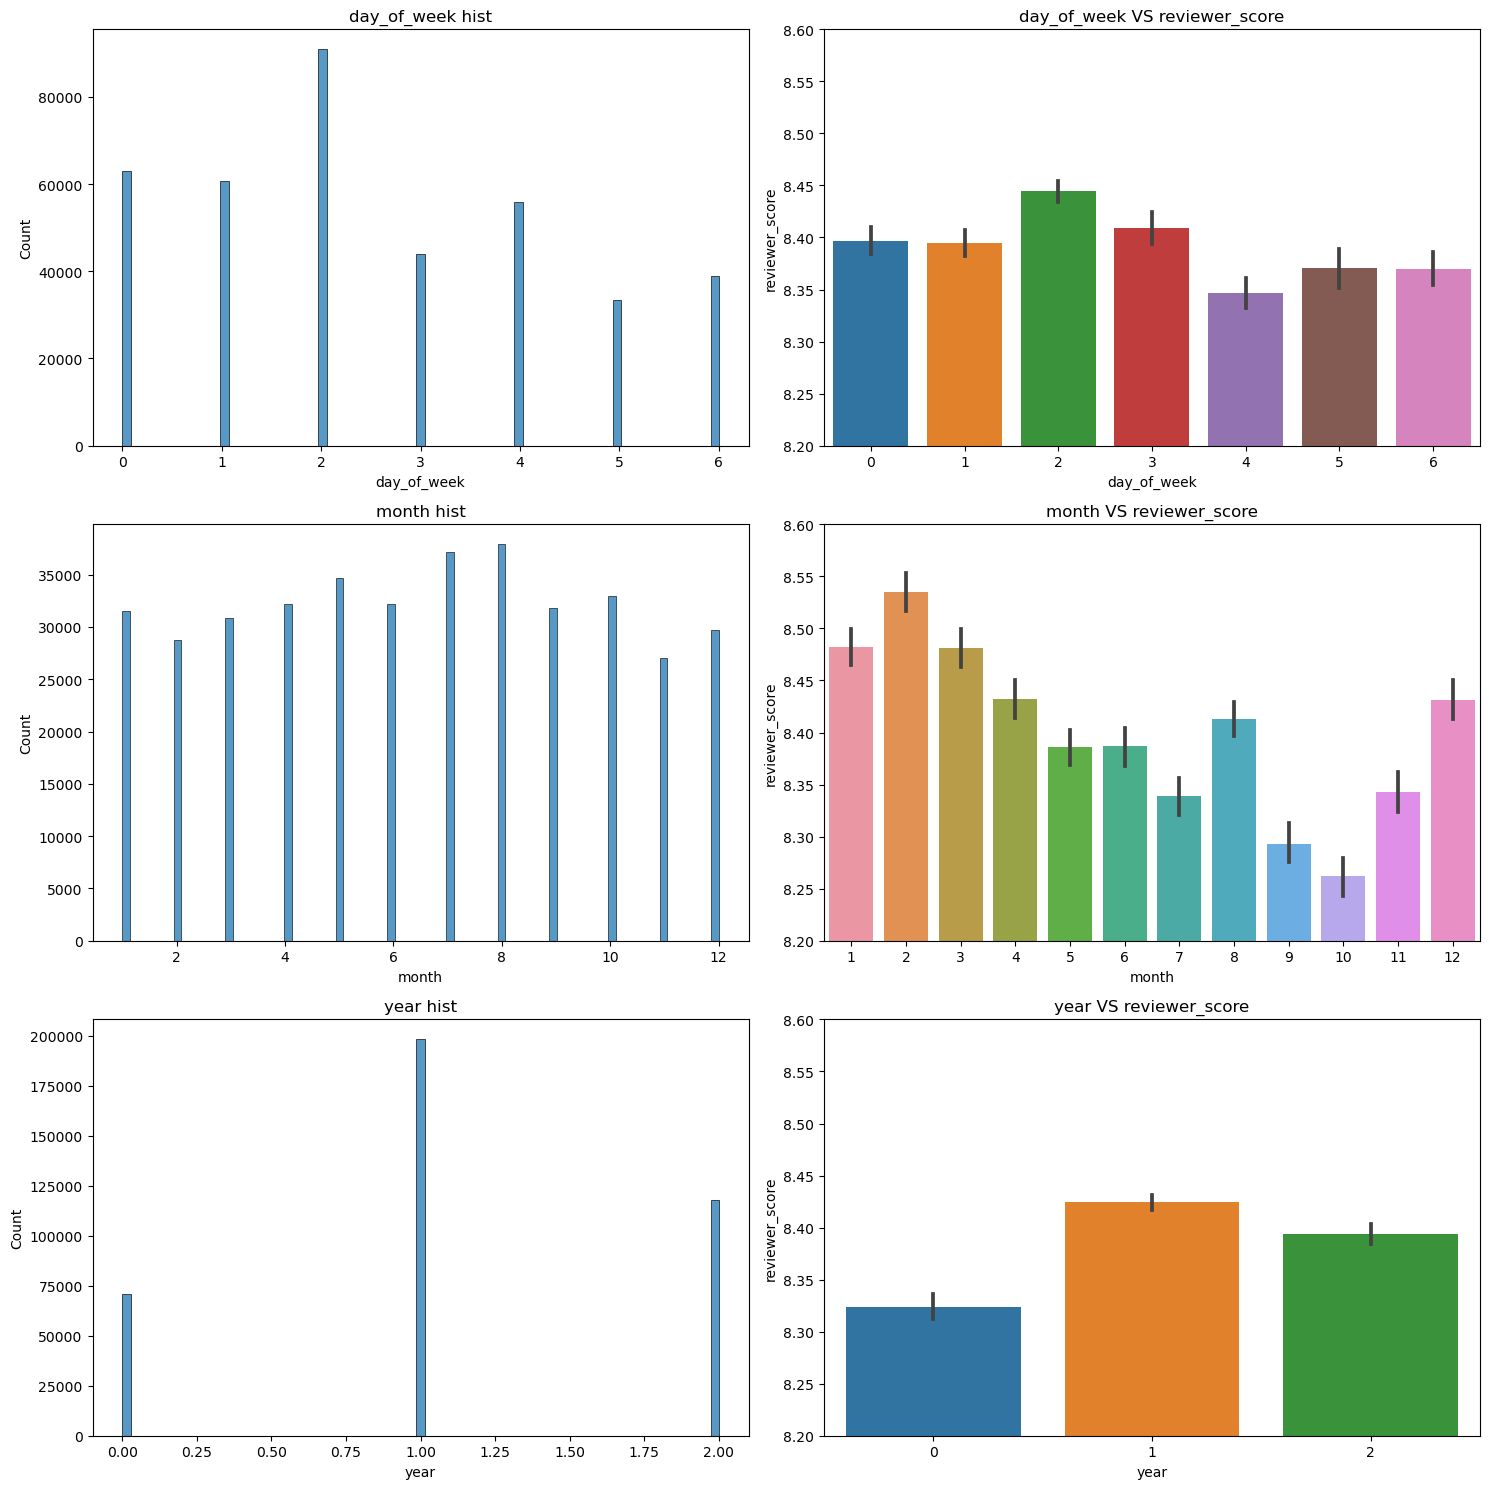

In [36]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 15)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data[data['sample']==1], x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    barplot = sns.barplot(data=data[data['sample']==1], x=feature, y='reviewer_score', ax=axes[i][1])
    barplot.set_ylim(8.2, 8.6)
    #Добавляем подпись графику
    barplot.set_title('{} VS reviewer_score'.format(feature));
plt.tight_layout() #выравнивание графиков

Есть влияние на таргет, но не сильно значительное. Здесь я решил создать новые составные признаки из полученных дней, годов и месяцев, так как мне показалось, что тем самым я помогу модели при обучении

In [37]:
# признак 'год-месяц'
data['year_month'] = data['year'] * 12 + data['month']
# признак месяц - день недели'
data['month_dow'] = (data['month'] - 1) * 7 + data['day_of_week']

data.drop(columns= ['month','year'], inplace=True) # удаляю "отработанные" столбцы с чистой совестью

In [38]:
num_features=['year_month','month_dow']

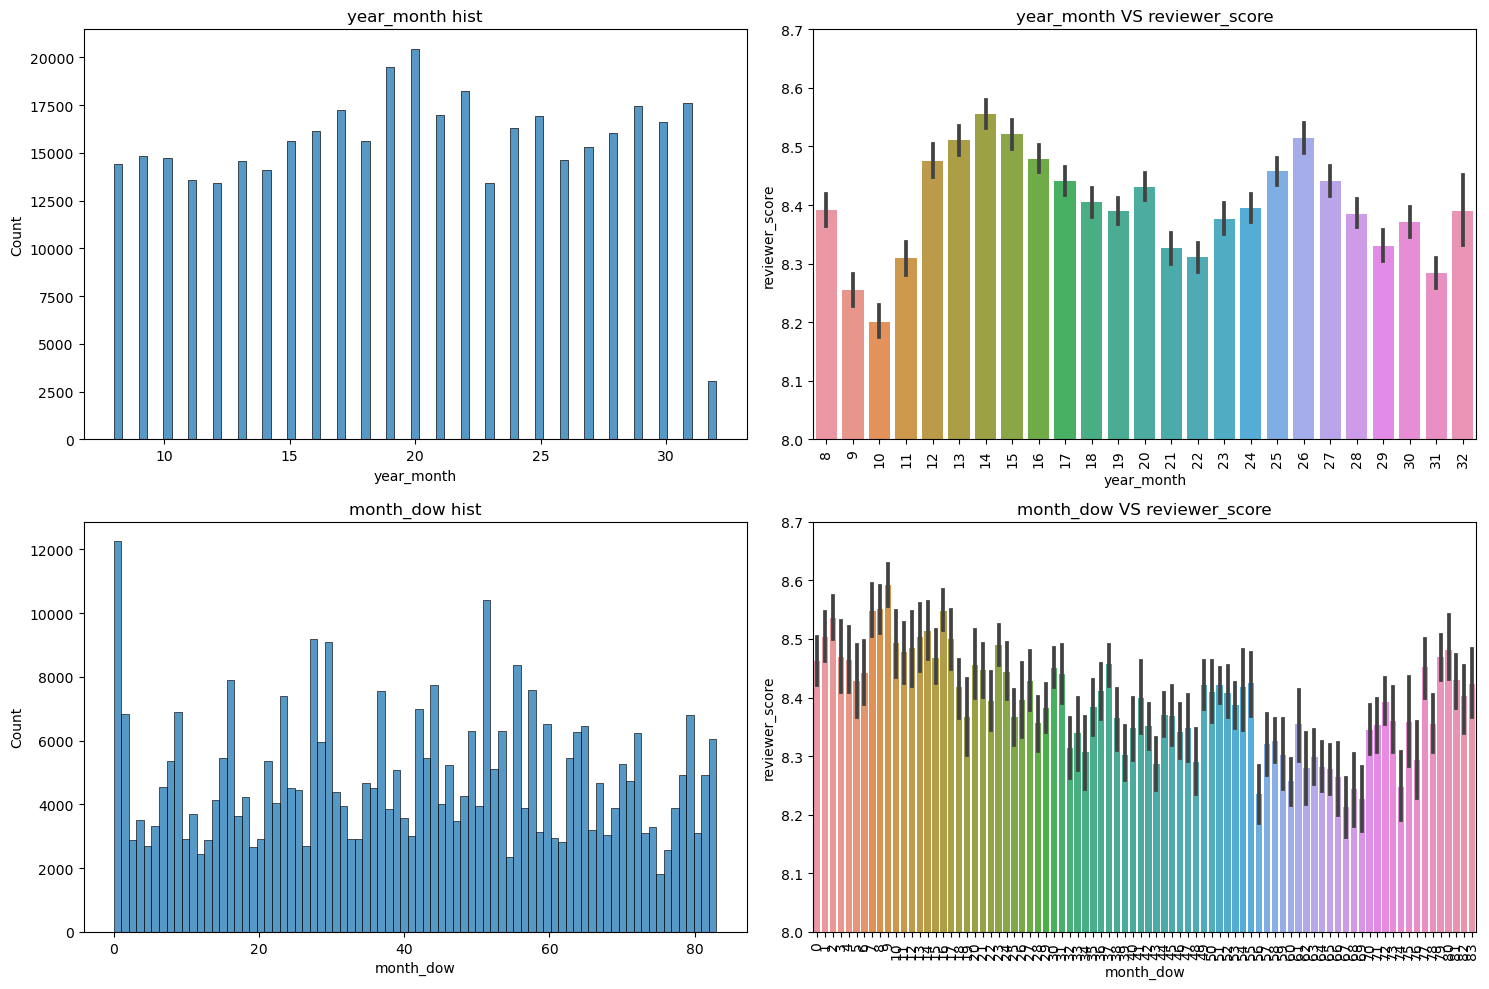

In [39]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 10)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data[data['sample']==1], x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим диаграмму рассеяния + линейную регрессию
    barplot = sns.barplot(data=data[data['sample']==1], x=feature, y='reviewer_score', ax=axes[i][1])
    barplot.set_ylim(8, 8.7)
    #Добавляем поворот отметок на оси абсцисс
    barplot.xaxis.set_tick_params(rotation=90)
    #Добавляем подпись графику
    barplot.set_title('{} VS reviewer_score'.format(feature));
plt.tight_layout() #выравнивание графиков

Мне кажется или стало интереснее? Кодирую полученные признаки бинарным кодированием.

In [40]:
bin_encoder = ce.BinaryEncoder(cols=['year_month']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['year_month'])
data = pd.concat([data, type_bin], axis=1)

In [41]:
bin_encoder = ce.BinaryEncoder(cols=['month_dow']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['month_dow'])
data = pd.concat([data, type_bin], axis=1)

#### 2.2.4 Признак 'average_score' (средняя оценка отеля за год).

Этот признак здесь говорит сам за себя. Числовой. Вмешательств не требует. В дальнешем будем его использвать интенсивно для создания новых признаков, так как скоррелированность с таргетом низкая, а зависимость высокая

#### 2.2.5 Признак 'hotel_name' (название отеля).

Здесь я не вижу ничего интересного для решения нашей задачи. Сети отелей или одиночные, звучный брэнд или никому неизвестный отель - я думаю, нет сильной зависимости. (ну и по секрету: я потратил все же время, чтобы это понять)

In [42]:
data.drop(columns= ['hotel_name'], inplace=True)

#### 2.2.6 Признак 'reviewer_nationality' (национальность рецензента).

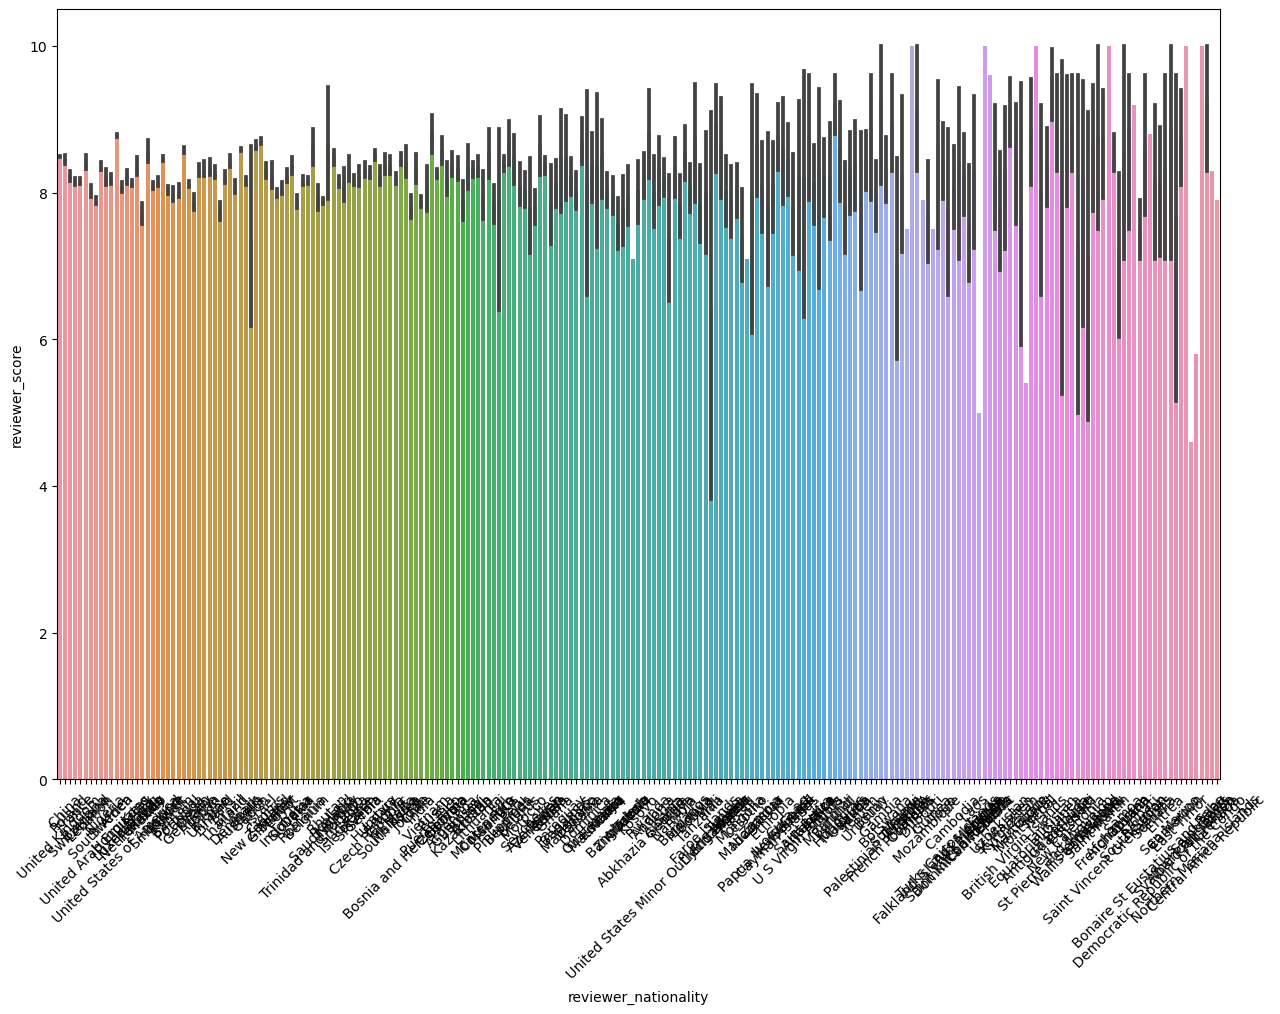

In [43]:
plt.rcParams['figure.figsize'] = (15,10)
barplot=sns.barplot(data=data[data['sample']==1], x='reviewer_nationality', y='reviewer_score',)
barplot.xaxis.set_tick_params(rotation=45)

Здесь, я думаю, можно этот признак применить для наших целей. 
Во-первых, сильно не разбираясь кого и сколько, сразу можно закодировать, причем бинарно, так как уникальных значений 227.  

In [44]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

Также, попробуем создать новый признак на основе этого и еще одного: 'total_number_of_reviews_reviewer_has_given' (общее количество отзывов рецензента), тем самым, пытаясь выявить рецензента, и, соответственно придать двум разным признакам новый смысл и вес. 

In [45]:
# создаем новый признак: среднее и так уже среднего 'average_score'
df = data.groupby(['total_number_of_reviews_reviewer_has_given', 'reviewer_nationality'])['average_score'].mean(). reset_index()
df.rename(columns = {'average_score':'give_nat_score'}, inplace = True)
data = pd.merge(data, df, how='left', on=['total_number_of_reviews_reviewer_has_given', 'reviewer_nationality'])

Также, попробуем закодировать признак национальности при помощи JamesSteinEncoder

In [46]:
JS_encoder = ce.JamesSteinEncoder(cols=['reviewer_nationality'])
data = JS_encoder.fit_transform(data, data['average_score'])

#### 2.2.7 Признак 'total_number_of_reviews' (общее количество отзывов).

Здесь оставим всё как есть.

#### 2.2.8 Признак 'total_number_of_reviews_reviewer_has_given' (общее количество отзывов, которое сделал рецензент).

Применил ранее, объеденив с национальностью. Используем дальше, как самостоятельный числовой признак. Может быть, он окажет свое влияние на общую картину.

#### 2.2.9 Признак 'tags' (тэги, информация о характере проживания в номере отеля).

Внимательно изучив это признак, я увидел список из максимум 6 значений, которые легко распределяютсы в следующие группы:
1. Вид путешествия. Здесь могут быть 2 значения: 'Leisure Trip', 'Business Trip', а также пустое неопределенное значение.
2. С кем в номере проживал гость. Здесь значений может быть 6: 'Couple', 'Solo traveler', 'Family with young children', 'Group', 'Family with older children', 'Travelers with friends'
3. Подтверждение бронирования с мобильного устройства. Значение одно 'Submitted from a mobile device' или отсутствие его.
4. С питомцем. Значение одно 'With a pet' или отсутствие его.
5. Количество прожитых ночей. 
6. Дополнительная информация о номере. Здесь уникальных значений, как выяснилось позже, может быть 2388 

Извлечем  из признака 'tags' 5 признаков и сразу их закодируем

In [47]:
# для начала сделаем признак удобным для дальнейшей работы
data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))

In [48]:
# напишем функцию для извлечения из списка необходимых значений и сразу придадим им числовые признаки
def rule(x):
    lst_1 = {'Leisure trip' : 1, 'Business trip' : 2}
    lst_2 = {'Couple' : 1, 'Solo traveler' : 2, 'Family with young children' : 4, 
             'Group' : 3, 'Family with older children' : 5, 'Travelers with friends' : 6}
    lst_3 = {'Submitted from a mobile device' : 1}
    lst_4 = {'With a pet' : 1}
    lst_5 = {'Stayed' : re.findall(r'(\d+)(?!.*\d)', str(x))}
    def circle(x, lst):
        for i in lst:
            if i in x:
                x.remove(i)
                return lst[i]
            if i in str(x):
                index = [ind for ind in range(len(x)) if x[ind].startswith('Stayed')][0]
                x.remove(x[index])
                return lst[i][0]
        return 0  
    trip_kind = circle(x, lst_1)
    travelers = circle(x, lst_2)
    submitted  = circle(x, lst_3)
    with_a_pet = circle(x, lst_4)
    nights = circle(x, lst_5)
    
    return trip_kind, travelers , submitted, with_a_pet, nights
 
data[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = data['tags'].apply(rule).to_list()
data[['trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']] = data[[
    'trip_kind', 'travelers', 'submitted', 'with_a_pet', 'nights']].astype('int8')

In [49]:
# закодируем количество ночей в бинарные признаки, но при этом оставим числовой признак количества ночей
bin_encoder = ce.BinaryEncoder(cols=['nights']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['nights'])
data = pd.concat([data, type_bin], axis=1)

In [50]:
# вот так вот жестко взорвав, я обошелся со списками, вытащив из них остатки признака 'tags', 
data = data.explode(['tags'])
data.fillna('', inplace = True)

In [51]:
# кодируем и этот признак
bin_encoder = ce.BinaryEncoder(cols=['tags']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(data['tags'])
data = pd.concat([data, type_bin], axis=1)

#### 2.2.10 Признак 'days_since_review' (прошло дней с момента озыва).

Оставим это признак как есть.

#### 2.2.11 Признаки 'lat' и 'lng' (широта и долгота отеля).

Здесь я хочу попробовать видоизменить этот признак в один: высчитать дистанцию до 5 топовых достопримечательностей в каждом городе.

In [52]:
# создадим словарь с координатами 5 топовых достопримечательностей по каждому городу
top_attractions_dictionary = {
    'Paris'    : [48.8675663, 2.3147773, 48.8739252, 2.2951306, 48.8582076, 2.2944752, 48.8609806, 2.3359009, 48.8529828, 2.3496592],
    'London'   : [51.5045382, -0.0866061, 51.5033054, -0.1195372, 51.505549, -0.075378, 51.500704, -0.1245475, 51.5012961, -0.1419034],
    'Barcelona': [41.3841655, 2.1763008, 41.3869879, 2.1700018, 41.4036071, 2.1743126, 41.3750493, 2.1491324, 41.4219528, 2.1188577],
    'Milan'    : [45.4742823, 9.2052561, 45.4643285, 9.1918834, 45.4674733, 9.1895466, 45.4705579, 9.1792248, 45.4010988, 9.1429617],
    'Vienna'   : [48.20774, 16.365837, 48.208543, 16.3729894, 48.2169083, 16.3960724, 48.2167505, 16.3980144, 48.1848829, 16.3120947],
    'Amsterdam': [52.365264, 4.9024094, 52.3563747, 4.8793185, 52.3598562, 4.8850799, 52.3731299, 4.8915264, 52.3750972, 4.8841021],
}

In [53]:
# рассчитаем суммарное значение расстояний от каждого отеля до каждой из пяти достопримечательности в каждом городе 
def distance_to_top_attraction(city, lat, lng):
    sum_distance = 0
    for i in range(0, 10, 2):
        lat1 = top_attractions_dictionary[city][i] * math.pi / 180
        lat2 = lat * math.pi / 180
        lng1 = top_attractions_dictionary[city][i + 1] * math.pi / 180
        lng2 = lng * math.pi / 180
        
        cl1 = math.cos(lat1)
        cl2 = math.cos(lat2)
        sl1 = math.sin(lat1)
        sl2 = math.sin(lat2)
        delta = lng2 - lng1
        cdelta = math.cos(delta)
        sdelta = math.sin(delta)
        
        y = math.sqrt(pow(cl2 * sdelta, 2) + pow(cl1 * sl2 - sl1 * cl2 * cdelta, 2))
        x = sl1 * sl2 + cl1 * cl2 * cdelta
        
        ad = math.atan(y / x) * 6372795 / 1000
        sum_distance += ad 
    return sum_distance

data['distance'] = data.apply(lambda x: distance_to_top_attraction(x.hotel_city, x.lat, x.lng), axis = 1)


In [54]:
# используем нормализацию (MaxMin), чтобы привети к общей шкале суммарные расстояния 
# до объектов достопримечательностей в каждом городе

city_list = data['hotel_city'].unique().tolist()
for city in city_list:
    mask = (data['hotel_city'] == city)
    data.loc[(mask), 'distance_norm'] = (
        data[mask]['distance'] - data[mask]['distance'].min ()) / (
        data[mask]['distance'].max() - data[mask]['distance'].min())
data.drop(columns = ['distance', 'lat', 'lng'], inplace=True) # удаляю "отработанные" столбцы

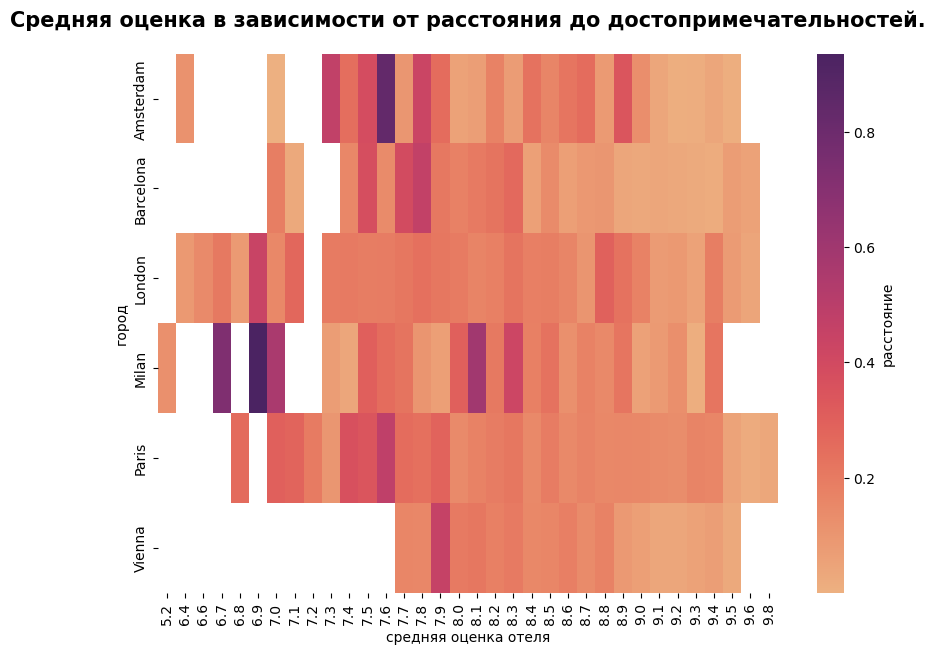

In [55]:
pivot_distance = data[data['sample']==1].pivot_table(
    values='distance_norm',
    columns='average_score',
    index='hotel_city')
pivot_distance.columns = pivot_distance.columns.astype('string')
fig, ax = plt.subplots(figsize=(10,7))    
heatmap = sns.heatmap(data=pivot_distance, cmap='flare', 
                      cbar_kws={'label': 'расстояние'})
heatmap.set_title('Средняя оценка в зависимости от расстояния до достопримечательностей.',
                  fontsize=15, fontweight='bold', pad=20);
heatmap.set_xlabel('средняя оценка отеля');
heatmap.set_ylabel('город');

У нас есть ещё четыре признака, которые я хочу также перекодировать:

In [56]:
data = pd.get_dummies(data, columns=['day_of_week','trip_kind', 'travelers', 'hotel_city' ])

#### 2.2.12 Признаки 'negative_review', 'positive_review', 'review_total_negative_word_counts', 'review_total_positive_word_counts'

Предположил, и далее понял, что не ошибся, что оценка рецензента сильно зависима от его положительного и отрицательного отзыва. Таким образом, я решил, что отзывам я и посвящу большую часть времени на изыскания. Сначала обработаю информацию в отзывах для более удобной дальнейшей работы с ними.

In [57]:
# приведем отзывы в удобный для работы вид: уберем боковые пробелы и сделаем заглавные буквы строчными
data['negative_review'] = data['negative_review'].apply(lambda x: x.strip().lower())
data['positive_review'] = data['positive_review'].apply(lambda x: x.strip().lower())

In [58]:
# изменим значения признаков количества слов в отзывах на правильные, только оставив 0 в отзывах "no positive" и 'no negative'
data.loc[data['review_total_negative_word_counts'] != 0, 
         'review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: x.count(' ') + 1)
data.loc[data['review_total_positive_word_counts'] != 0, 
         'review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: x.count(' ') + 1)


Посмотрим, что представляют из себя негативные и позитивные отзывы

In [59]:
data['negative_review'].value_counts().head(50)

no negative                       127890
nothing                            21185
n a                                 1815
none                                1501
                                     849
nothing really                       656
small room                           570
all good                             545
breakfast                            545
no complaints                        523
location                             502
nothing at all                       467
everything                           420
nothing to dislike                   373
price                                348
nil                                  332
small rooms                          307
everything was perfect               276
na                                   272
can t think of anything              250
leaving                              244
absolutely nothing                   242
everything was great                 222
expensive                            206
nothing to compl

In [60]:
data['positive_review'].value_counts().head(50)

no positive                      35946
location                         11945
everything                        3314
nothing                           1731
great location                    1687
the location                      1606
good location                     1496
breakfast                          795
friendly staff                     733
excellent location                 639
staff                              553
location and staff                 452
location staff                     432
location location location         345
location was great                 328
good breakfast                     316
everything was perfect             316
location was good                  312
comfy bed                          303
perfect location                   287
the staff                          281
location is great                  280
location is good                   256
all                                250
clean                              237
every thing              

Для дальнейшей работы, считаю необходимым, изменить некоторые отзывы, придав им более эмоциональную окраску

In [61]:
# ввожу функцию создания списка фраз из тех рецензий, которые попадают под определенные условия
def phrases_median_count(df, med_min, med_max, cnt):
    df.columns = ['phrases', 'median', 'count']
    df_cond = df[(df['median']>=med_min) & (df['median']<=med_max) & (df['count']>=cnt)]
    return list(df_cond['phrases'])

In [62]:
# для более точного определения эмоциональной окраски отрицательных отзывов 
# выявим в тренировочных данных фразы с количеством слов менее или равно 9 (оптимально подобранное кол-во), 
# аггрегируем по медианному значению оценки резензента и количеству повторений отзывов
neg_df = data[(data['review_total_negative_word_counts'] <= 9) & (data['sample'] == 1)].groupby(
    ['negative_review']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# для списка явнопозитивных отзывов отберем только повторяющиеся отзывы (чтобы не переобучить модель)
# и с медианной оценкой больше или равно 9,5 
# обращаемся к ранее созданной функции
neg_lst_pos = phrases_median_count(neg_df, 9.5, 10, 2)

# для списка явнонегативных отзывов отберем только повторяющиеся отзывы (чтобы не переобучить модель)
# и с медианной оценкой меньше или равно 6,0
# обращаемся к ранее созданной функции
neg_lst_neg = phrases_median_count(neg_df, 0, 6, 2)

In [63]:
# для более точного определения эмоциональной окраски положительных отзывов 
# выявим в тренировочных данных фразы с количеством слов менее или равно 7 (оптимально подобранное кол-во), 
# аггрегируем по медианному значению оценки резензента и количеству повторений отзывов
pos_df = data[(data['review_total_positive_word_counts'] <= 7) & (data['sample'] == 1)].groupby(
    ['positive_review']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# для списка явнопозитивных отзывов отберем только повторяющиеся отзывы (чтобы не переобучить модель)
# и с медианной оценкой больше или равно 9.5 
# обращаемся к ранее созданной функции
pos_lst_pos = phrases_median_count(pos_df, 9.5, 10, 2)

# для списка явнонегативных отзывов отберем только повторяющиеся отзывы (чтобы не переобучить модель)
# и с медианной оценкой меньше или равно 6.0
# обращаемся к ранее созданной функции
pos_lst_neg = phrases_median_count(pos_df, 0, 6, 2)

In [64]:
# придадим явнопозитивным и явнонегативным отзывам явную эмоциональную окраску, заменив их на 'negative' или 'positive'
def get_new_review(review, lst_pos, lst_neg):
    if review in lst_pos:
        return 'positive'
    if review in lst_neg:
        return 'negative'
    return review

data['negative_review'] = data['negative_review'].apply(lambda negative_review: get_new_review(negative_review, neg_lst_pos, neg_lst_neg))
data['positive_review'] = data['positive_review'].apply(lambda positive_review: get_new_review(positive_review, pos_lst_pos, pos_lst_neg))


In [65]:
# создадим новые признаки с нулевым количеством слов для явнопозитивных и явнонегативных отзывов
data['colneg'] = data['review_total_negative_word_counts']
data['colpos'] = data['review_total_positive_word_counts']
data.loc[data['negative_review'] == 'positive', 'colneg'] = 0
data.loc[data['positive_review'] == 'negative', 'colpos'] = 0

In [66]:
# построим гистограмму распределения количества слов в негативных отзывах и коробку с усами
# значения с количеством слов равное 0 исключим, как уже отработанные и неинформативные для наших следующих изысканий
fig = px.histogram(
    data_frame=data[data['colneg']>0],
    x='colneg',
    title='Распределение количества слов в негативных отзывах',
    nbins=90,
    marginal='box',
    width=1000,
)
fig.show()

In [67]:
# построим гистограмму распределения количества слов в позитивных отзывах и коробку с усами
# значения с количеством слов равное 0 исключим, как уже отработанные и неинформативные для наших следующих изысканий
fig = px.histogram(
    data_frame=data[data['colpos']>0],
    x='colpos',
    title='Распределение количества слов в позитивных отзывах',
    nbins=90,
    marginal='box',
    width=1000,
)
fig.show()

Посмотрим диаграммы распределения количества слов в отзывах

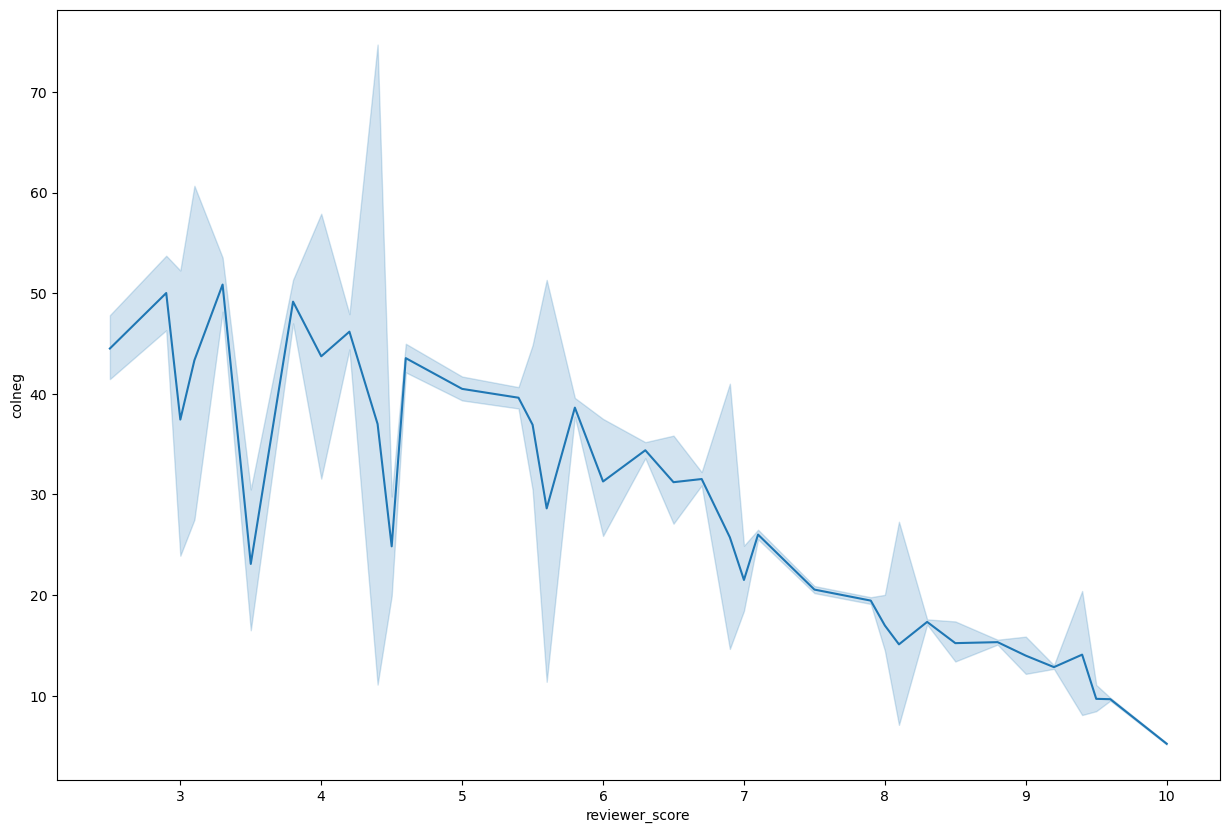

In [68]:
sns.lineplot(
    x="reviewer_score", 
    y="colneg", 
    data=data[(data['sample']==1) & (data['colneg']>=0)])
plt.show()

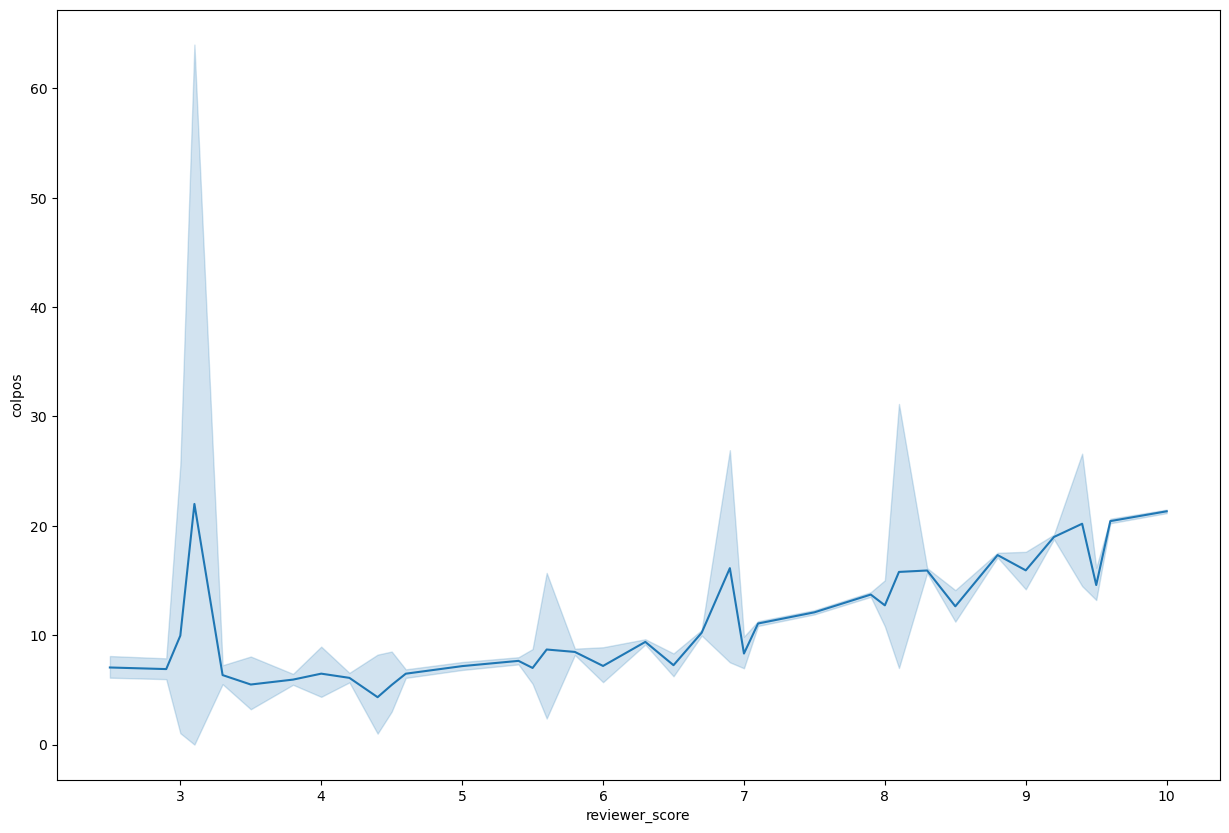

In [69]:
sns.lineplot(
    x="reviewer_score", 
    y="colpos", 
    data=data[(data['sample']==1) & (data['colpos']>=0)])
plt.show()

Отсюда делаю вывод: оценка рецензента прямо пропорциональна количеству слов в позитивном отзыве и обратно пропорциональна количеству слов в негативном отзыве, и эта зависимость практически линейна. Для этих целей создам шаблон принудительной зависимости количества слов от оценки рецензента, по которому в дальнейшем будут определяться новые признаки:
1.  В негативных отзывах:   
*                         количество слов 0 - оценка рецензента более или равная 9.5 (условная нулевая отметка),
*                         количество слов 7 - оценка рецензента более или равная 9, но менее 9.5 (1-й квартиль),
*                         количество слов 15 - оценка рецензента более или равная 7, но менее 9 (медиана),
*                         количество слов 31 - оценка рецензента более или равная 6, но менее 7 (3-й квартиль),
*                         количество слов 67 - оценка рецензента менее 6 (верхняя граница ящика с усами)
2.  В позитивных отзывах:   
*                        количество слов 47 - оценка рецензента более или равная 9.5 (верхняя граница ящика с усами),
*                        количество слов 22 - оценка рецензента более или равная 9, но менее 9.5 (3-й квартиль),
*                        количество слов 11 - оценка рецензента более или равная 7, но менее 9 (медиана),
*                        количество слов 5 - оценка рецензента более или равная 6, но менее 7 (1-й квартиль),
*                        количество слов 0 - оценка рецензента менее 6 (условная нулевая отметка)

Понимая, что многие отзывы не имеют такой прямой зависимости, добавляю в новые признаки количества слов, полученную информацию из шаблонов. 

In [70]:
# сгруппируем все негативные отзывы из трейна и по ним определим медианное значение оценок рецензентов и их количество
neg_rev = data[data['sample'] == 1].groupby(['negative_review']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# с помощью ранее созданной функции, находим только повторяющиеся списки отзывов с необходимыми условиями
neg_lst_0 = phrases_median_count(neg_rev, 9.5, 10, 2)
neg_lst_7 = phrases_median_count(neg_rev, 9, 9.49, 2)
neg_lst_15 = phrases_median_count(neg_rev, 7, 8.99, 2)
neg_lst_31 = phrases_median_count(neg_rev, 6, 6.99, 2)
neg_lst_67 = phrases_median_count(neg_rev, 0, 5.99, 2)

# Функция, возвращающая количество слов,зависящее от медианных оценок отзывов
def get_count_words_neg(neg_review):
    if neg_review in neg_lst_67:
        return 67
    if neg_review in neg_lst_31:
        return 31
    if neg_review in neg_lst_15:
        return 15
    if neg_review in neg_lst_7:
        return 7
    if neg_review in neg_lst_0:
        return 0
    return neg_review.count(' ') + 1

# перезапишем новые значения количества слов в созданный ранее признак 
data['colneg'] = data['negative_review'].apply(get_count_words_neg)

In [71]:
# сгруппируем все позитивные отзывы из трейна и по ним определим медианное значение оценок рецензентов и их количество
pos_rev = data[data['sample'] == 1].groupby(['positive_review']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# с помощью ранее созданной функции, находим списки отзывов с необходимыми условиями
pos_lst_47 = phrases_median_count(pos_rev, 9.5, 10, 2)
pos_lst_22 = phrases_median_count(pos_rev, 9, 9.49, 2)
pos_lst_11 = phrases_median_count(pos_rev, 7, 8.99, 2)
pos_lst_5 = phrases_median_count(pos_rev, 6, 6.99, 2)
pos_lst_0 = phrases_median_count(pos_rev, 0, 5.99, 2)

# Функция, возвращающая количество слов,зависящее от медианных оценок отзывов
def get_count_words_pos(pos_review):
    if pos_review in pos_lst_47:
        return 47
    if pos_review in pos_lst_22:
        return 22
    if pos_review in pos_lst_11:
        return 11
    if pos_review in pos_lst_5:
        return 5
    if pos_review in pos_lst_0:
        return 0
    return pos_review.count(' ') + 1

# перезапишем новые значения количества слов в созданный ранее признак 
data['colpos'] = data['positive_review'].apply(get_count_words_pos)

Введу новый признак: среднеарифметическое каждой рецензии на основе среднеарифметического каждого слова(пары и тройки слов), которое в свою очередь я получаю из среднеарифметической оценки отеля, в отзывах, которого есть такое слово.

In [72]:
# создадим новые признаки со списком слов из каждого отзыва 
data['splitted_negative_review'] = data.negative_review.apply(lambda x: x.split())
data['splitted_positive_review'] = data.positive_review.apply(lambda x: x.split())

# напишем функцию создания нового признака со списком пар слов, следующими друг за другом в каждом отзыве
def pair_words(splitted_review):
    pair = []
    for i in range(0,len(splitted_review)-1):
        pair.append(splitted_review[i]+" "+splitted_review[i+1])   
    pair = pair if len(splitted_review) != 1 else [splitted_review[0]] 
    return pair

data['splitted_negative_review_2'] = data['splitted_negative_review'].apply(pair_words)
data['splitted_positive_review_2'] = data['splitted_positive_review'].apply(pair_words)

# напишем функцию создания нового признака со списком троек слов, следующими друг за другом в каждом отзыве
def triple_words(splitted_review):
    triple = []
    if len(splitted_review) == 1:
        return [splitted_review[0]]
    if len(splitted_review) == 2:
        return [splitted_review[0]+" "+splitted_review[1]]      
    for i in range(0,len(splitted_review)-2):
        triple.append(splitted_review[i]+" "+splitted_review[i+1]+" "+splitted_review[i+2])               
    return triple

data['splitted_negative_review_3'] = data['splitted_negative_review'].apply(triple_words)
data['splitted_positive_review_3'] = data['splitted_positive_review'].apply(triple_words)

In [73]:
%%time
# используем функцию "взрыва" для разделения в датафрейме каждого слова, пары и тройки слов из отзывов 
# и занесем эту информацию в новые датафреймы
def explode_review(splitted_review):
    return data.explode(splitted_review)[[splitted_review,'average_score','reviewer_score', 'sample']]

df_exploded_negative_reviews_1 = explode_review('splitted_negative_review')
df_exploded_positive_reviews_1 = explode_review('splitted_positive_review')
df_exploded_negative_reviews_2 = explode_review('splitted_negative_review_2')
df_exploded_positive_reviews_2 = explode_review('splitted_positive_review_2')
df_exploded_negative_reviews_3 = explode_review('splitted_negative_review_3')
df_exploded_positive_reviews_3 = explode_review('splitted_positive_review_3')

CPU times: user 2min 7s, sys: 1min 22s, total: 3min 30s
Wall time: 3min 29s


In [74]:
# напишем функцию для создания словаря, где в качестве ключей будут слова, пары и тройки слов из отзывов, 
# а значения - среднее значение из столбца 'average_score', таким образом придав вес каждому слову, паре и тройке слов из всех отзывов
def review_words_average_score(exploded_review, group):
    # сгруппируем данные из нового датафрейме по "взорванному" признаку с результирущей колонкой среднее по 'average_score'
    explode_average_score = exploded_review.groupby(group)['average_score'].mean().reset_index()
    # создадим словарь
    dic = dict([(i, j) for i, j in zip(explode_average_score[group], explode_average_score['average_score'])])   
    return dic

neg_dic_1 = review_words_average_score(df_exploded_negative_reviews_1, 'splitted_negative_review')    
pos_dic_1 = review_words_average_score(df_exploded_positive_reviews_1, 'splitted_positive_review') 
neg_dic_2 = review_words_average_score(df_exploded_negative_reviews_2, 'splitted_negative_review_2')
pos_dic_2 = review_words_average_score(df_exploded_positive_reviews_2, 'splitted_positive_review_2')
neg_dic_3 = review_words_average_score(df_exploded_negative_reviews_3, 'splitted_negative_review_3')
pos_dic_3 = review_words_average_score(df_exploded_positive_reviews_3, 'splitted_positive_review_3')

In [75]:
# напишем функцию, которая создает новый признак в нашем датафрейме: это средеарифметическое всех слов, пар и троек слов 
# в рецензиях, которые встречаются в словаре, используя значения 'average_score' созданных ранее словарей 
def review_average_score(splitted_review, dic):
    avg = 0
    for i in splitted_review:
        if i in dic:
            avg = avg + dic[i]     
    col = len(splitted_review) if len(splitted_review) != 0 else 1
    return avg/col

data['negative_reviews_score_1'] = data['splitted_negative_review'].apply(lambda splitted_review: review_average_score(splitted_review, neg_dic_1))
data['positive_reviews_score_1'] = data['splitted_positive_review'].apply(lambda splitted_review: review_average_score(splitted_review, pos_dic_1))
data['negative_reviews_score_2'] = data['splitted_negative_review_2'].apply(lambda splitted_review: review_average_score(splitted_review, neg_dic_2))
data['positive_reviews_score_2'] = data['splitted_positive_review_2'].apply(lambda splitted_review: review_average_score(splitted_review, pos_dic_2))
data['negative_reviews_score_3'] = data['splitted_negative_review_3'].apply(lambda splitted_review: review_average_score(splitted_review, neg_dic_3))
data['positive_reviews_score_3'] = data['splitted_positive_review_3'].apply(lambda splitted_review: review_average_score(splitted_review, pos_dic_3))

А теперь я хочу попробовать выбрать отзывы, попадающие в определенные интервалы медианных оценок рецезентов, разделить их на слова, пары и тройки слов, а потом по этим найденным фразам расставить более точно новые значения количества слов.

In [76]:
# для новых датафреймов выбираю рецензии, повторяющиеся более 9 раз и в определенных интервалах 
# (более 9.5 и менее 6 не беру, так как там при таких условиях остались отзывы 'positive' или 'negative')
neg_rev_9 = neg_rev[(neg_rev['median']>=9) & (neg_rev['median']<9.5) & (neg_rev['count']>=10)]
pos_rev_9 = pos_rev[(pos_rev['median']>=9) & (pos_rev['median']<9.5) & (pos_rev['count']>=10)]
neg_rev_7 = neg_rev[(neg_rev['median']>=7) & (neg_rev['median']<9) & (neg_rev['count']>=10)]
pos_rev_7 = pos_rev[(pos_rev['median']>=7) & (pos_rev['median']<9) & (pos_rev['count']>=10)]
neg_rev_6 = neg_rev[(neg_rev['median']>=6) & (neg_rev['median']<7) & (neg_rev['count']>=10)]
pos_rev_6 = pos_rev[(pos_rev['median']>=6) & (pos_rev['median']<7) & (pos_rev['count']>=10)]


In [77]:
# чтобы избежать предупреждения pandas о цепном назначении, использую такой код
pd.options.mode.chained_assignment = None

# создадим в новых датафремах новые признаки со списком слов из каждого отзыва 
neg_rev_9['splitted_negative_review'] = neg_rev_9.phrases.apply(lambda x: x.split())
pos_rev_9['splitted_positive_review'] = pos_rev_9.phrases.apply(lambda x: x.split())
neg_rev_7['splitted_negative_review'] = neg_rev_7.phrases.apply(lambda x: x.split())
pos_rev_7['splitted_positive_review'] = pos_rev_7.phrases.apply(lambda x: x.split())
neg_rev_6['splitted_negative_review'] = neg_rev_6.phrases.apply(lambda x: x.split())
pos_rev_6['splitted_positive_review'] = pos_rev_6.phrases.apply(lambda x: x.split())

# напишем функцию создания нового признака со списком пар слов, следующими друг за другом в каждом отзыве
def pair_words(splitted_review):
    pair = []
    for i in range(0,len(splitted_review)-1):
        pair.append(splitted_review[i]+" "+splitted_review[i+1])   
    pair = pair if len(splitted_review) != 1 else [splitted_review[0]] 
    return pair

neg_rev_9['splitted_negative_review_2'] = neg_rev_9['splitted_negative_review'].apply(pair_words)
pos_rev_9['splitted_positive_review_2'] = pos_rev_9['splitted_positive_review'].apply(pair_words)
neg_rev_7['splitted_negative_review_2'] = neg_rev_7['splitted_negative_review'].apply(pair_words)
pos_rev_7['splitted_positive_review_2'] = pos_rev_7['splitted_positive_review'].apply(pair_words)
neg_rev_6['splitted_negative_review_2'] = neg_rev_6['splitted_negative_review'].apply(pair_words)
pos_rev_6['splitted_positive_review_2'] = pos_rev_6['splitted_positive_review'].apply(pair_words)

# напишем функцию создания нового признака со списком троек слов, следующими друг за другом в каждом отзыве
def triple_words(splitted_review):
    triple = []
    if len(splitted_review) == 1:
        return [splitted_review[0]]
    if len(splitted_review) == 2:
        return [splitted_review[0]+" "+splitted_review[1]]      
    for i in range(0,len(splitted_review)-2):
        triple.append(splitted_review[i]+" "+splitted_review[i+1]+" "+splitted_review[i+2])               
    return triple

neg_rev_9['splitted_negative_review_3'] = neg_rev_9['splitted_negative_review'].apply(triple_words)
pos_rev_9['splitted_positive_review_3'] = pos_rev_9['splitted_positive_review'].apply(triple_words)
neg_rev_7['splitted_negative_review_3'] = neg_rev_7['splitted_negative_review'].apply(triple_words)
pos_rev_7['splitted_positive_review_3'] = pos_rev_7['splitted_positive_review'].apply(triple_words)
neg_rev_6['splitted_negative_review_3'] = neg_rev_6['splitted_negative_review'].apply(triple_words)
pos_rev_6['splitted_positive_review_3'] = pos_rev_6['splitted_positive_review'].apply(triple_words)

In [78]:
# следующая функция будет собирать списки с фразами из найденных нами выше отзывов
def expl_lst(review, col):
    expl_rev = review.explode(col)[[col,'median']]
    return list(expl_rev[expl_rev[col].str.len()>3].groupby(col)['median'].mean(). reset_index()[col])

In [79]:
# найдем списки фраз для отзывов в наших 4-х интервалах
lst_exploded_neg_rev_9_1 = expl_lst(neg_rev_9, 'splitted_negative_review')
lst_exploded_pos_rev_9_1 = expl_lst(pos_rev_9, 'splitted_positive_review')
lst_exploded_neg_rev_9_2 = expl_lst(neg_rev_9, 'splitted_negative_review_2')
lst_exploded_pos_rev_9_2 = expl_lst(pos_rev_9, 'splitted_positive_review_2')
lst_exploded_neg_rev_9_3 = expl_lst(neg_rev_9, 'splitted_negative_review_3')
lst_exploded_pos_rev_9_3 = expl_lst(pos_rev_9, 'splitted_positive_review_3')
lst_exploded_neg_rev_7_1 = expl_lst(neg_rev_7, 'splitted_negative_review')
lst_exploded_pos_rev_7_1 = expl_lst(pos_rev_7, 'splitted_positive_review')
lst_exploded_neg_rev_7_2 = expl_lst(neg_rev_7, 'splitted_negative_review_2')
lst_exploded_pos_rev_7_2 = expl_lst(pos_rev_7, 'splitted_positive_review_2')
lst_exploded_neg_rev_7_3 = expl_lst(neg_rev_7, 'splitted_negative_review_3')
lst_exploded_pos_rev_7_3 = expl_lst(pos_rev_7, 'splitted_positive_review_3')
lst_exploded_neg_rev_6_1 = expl_lst(neg_rev_6, 'splitted_negative_review')
lst_exploded_pos_rev_6_1 = expl_lst(pos_rev_6, 'splitted_positive_review')
lst_exploded_neg_rev_6_2 = expl_lst(neg_rev_6, 'splitted_negative_review_2')
lst_exploded_pos_rev_6_2 = expl_lst(pos_rev_6, 'splitted_positive_review_2')
lst_exploded_neg_rev_6_3 = expl_lst(neg_rev_6, 'splitted_negative_review_3')
lst_exploded_pos_rev_6_3 = expl_lst(pos_rev_6, 'splitted_positive_review_3')

In [80]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_neg_2(neg_review):
    for phrase in neg_review:
        if phrase in lst_exploded_neg_rev_9_3:
            return 7
        if phrase in lst_exploded_neg_rev_7_3:
            return 15
        if phrase in lst_exploded_neg_rev_6_3:
            return 31 
    return -1

data['colneg_1'] = data['splitted_negative_review_2'].apply(get_count_words_neg_2)


CPU times: user 38 s, sys: 21.4 ms, total: 38.1 s
Wall time: 38.1 s


In [81]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_neg_2(neg_review):
    for phrase in neg_review:
        if phrase in lst_exploded_neg_rev_9_2:
            return 7
        if phrase in lst_exploded_neg_rev_7_2:
            return 15
        if phrase in lst_exploded_neg_rev_6_2:
            return 31
    return -1

data.loc[data['colneg_1'] == -1, 'colneg_1'] = data['splitted_negative_review_2'].apply(get_count_words_neg_2)


CPU times: user 17.8 s, sys: 8.55 ms, total: 17.8 s
Wall time: 17.8 s


In [82]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_neg_2(neg_review):
    for phrase in neg_review:
        if phrase in lst_exploded_neg_rev_9_1:
            return 7
        if phrase in lst_exploded_neg_rev_7_1:
            return 15 
        if phrase in lst_exploded_neg_rev_6_1:
            return 31     
    return -2

data.loc[data['colneg_1'] == -1, 'colneg_1'] = data['splitted_negative_review'].apply(get_count_words_neg_2)
data.loc[data['colneg_1'] == -2, 'colneg_1'] = data['colneg']


CPU times: user 4.6 s, sys: 1.46 ms, total: 4.6 s
Wall time: 4.6 s


In [83]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_pos_2(pos_review):
    for phrase in pos_review:
        if phrase in lst_exploded_pos_rev_6_3:
            return 5
        if phrase in lst_exploded_pos_rev_7_3:
            return 11
        if phrase in lst_exploded_pos_rev_9_3:
            return 22   
    return -1

data['colpos_1'] = data['splitted_positive_review_3'].apply(get_count_words_pos_2)


CPU times: user 44.7 s, sys: 18.7 ms, total: 44.7 s
Wall time: 44.7 s


In [84]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_pos_2(pos_review):
    for phrase in pos_review:
        if phrase in lst_exploded_pos_rev_6_2:
            return 5
        if phrase in lst_exploded_pos_rev_7_2:
            return 11
        if phrase in lst_exploded_pos_rev_9_2:
            return 22 
    return -1

data.loc[data['colpos_1'] == -1, 'colpos_1'] = data['splitted_positive_review_2'].apply(get_count_words_pos_2)

CPU times: user 12.9 s, sys: 8.63 ms, total: 12.9 s
Wall time: 12.9 s


In [85]:
%%time
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_pos_2(pos_review):
    for phrase in pos_review:
        if phrase in lst_exploded_pos_rev_6_1:
            return 5
        if phrase in lst_exploded_pos_rev_7_1:
            return 11
        if phrase in lst_exploded_pos_rev_9_1:
            return 22    
    return -2

data.loc[data['colpos_1'] == -1, 'colpos_1'] = data['splitted_positive_review'].apply(get_count_words_pos_2)
data.loc[data['colpos_1'] == -2, 'colpos_1'] = data['colpos']

CPU times: user 2.85 s, sys: 807 µs, total: 2.85 s
Wall time: 2.85 s


Далее, я опять решил поэксперементировать с признаками количества слов, группируя резюме по первым 11 символам

In [86]:
%%time
# сначала создаю новый признак с первыми 11 символами каждого негативного отзыва 
# (или менее если символов в рецензии меньше 11) 
data['neg_11'] = data['negative_review'].apply(lambda x: x[0:11] if (len(x) >= 11) else x)
# затем создаю новый датафрейм сгруппированный по колонке созданного признака 
# и аггрегированного по медианному значению оценки рецензента и количеству уникальных значений
neg_11 = data[(data['sample'] == 1)].groupby(['neg_11']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# обращаемся к ранее созданной функции для создания шаблонных списков для повторяющихся более 3 раз значений нового признака
neg_lst_0 = phrases_median_count(neg_11, 9.5, 10, 4)
neg_lst_7 = phrases_median_count(neg_11, 9, 9.49, 4)
neg_lst_15 = phrases_median_count(neg_11, 7, 8.99, 4)
neg_lst_31 = phrases_median_count(neg_11, 6, 6.99, 4)
neg_lst_67 = phrases_median_count(neg_11, 0, 5.99, 4)

# обращаемся к функции для создания нового признака количества слов в негативной рецензии, проверяя начинается ли отзыв с 11 символов в каждом из списке,
# и возвращаем соответствующее шаблонное количество слов, либо реальное количество слов, если начало отзыва отсутствует в списках 

data['colneg_2'] = data['neg_11'].apply(get_count_words_neg)

CPU times: user 1min 39s, sys: 323 ms, total: 1min 39s
Wall time: 1min 39s


In [87]:
%%time
# также и с положительными отзывами: сначала создаю новый признак с первыми 11 символами каждого отзыва 
# (или менее если символов в резензии меньше 11) 
data['pos_11'] = data['positive_review'].apply(lambda x: x[0:11] if (len(x) >= 11) else x)
# затем создаю новый датафрейм сгруппированный по колонке созданного признака 
# и аггрегированного по медианному значению оценки рецензента и количеству уникальных значений
pos_11 = data[(data['sample'] == 1)].groupby(['pos_11']).agg({'reviewer_score': ['median', 'count']}). reset_index()

# обращаемся к ранее созданной функции для создания шаблонных списков для повторяющихся более 3 раз значений нового признака
pos_lst_0 = phrases_median_count(pos_11, 0, 5.99, 4)
pos_lst_5 = phrases_median_count(pos_11, 6, 6.99, 4)
pos_lst_11 = phrases_median_count(pos_11, 7, 8.99, 4)
pos_lst_22 = phrases_median_count(pos_11, 9, 9.49, 4)
pos_lst_47 = phrases_median_count(pos_11, 9.5, 10, 4)

# обращаемся к функции для создания нового признака количества слов в негативной рецензии, проверяя начинается ли отзыв с 11 символов в каждом из списке,
# и возвращаем соответствующее шаблонное количество слов, либо реальное количество слов, если начало отзыва отсутствует в списках 
data['colpos_2'] = data['pos_11'].apply(get_count_words_pos)

CPU times: user 1min 6s, sys: 228 ms, total: 1min 6s
Wall time: 1min 6s


In [88]:
JS_encoder = ce.JamesSteinEncoder(cols=['neg_11'])
data = JS_encoder.fit_transform(data, data['average_score'])

In [89]:
JS_encoder = ce.JamesSteinEncoder(cols=['pos_11'])
data = JS_encoder.fit_transform(data, data['average_score'])

Мы создали новые признаки с шаблонным количеством слов в каждой рецензии, исходя из того, с чего начинается рецензия (часто определяющим главную мысль предложения  являются слова в начале предложения). Теперь попробуем определить еще новые признаки с шаблонным количеством слов по условию вхождения частоупотребляемых слов(пары, тройки), встречаемых  отзывах с высокими оценками и низкими

In [90]:
# определим функцию возврата шаблонного значения количества слов для негативных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_neg_3(neg_review):
    for phrase in neg_review:
        if phrase in neg_lst_0:
            return 0
        if phrase in neg_lst_7:
            return 7 
        if phrase in neg_lst_31:
            return 31 
        if phrase in neg_lst_67:
            return 67      
    return 15

In [91]:
# определим функцию возврата шаблонного значения количества слов для позитивных рецензий, 
# исходя из условия вхождения частоупотребляемых слов в тот или иной список
def get_count_words_pos_3(pos_review):
    for phrase in pos_review: 
        if phrase in pos_lst_0:
            return 0
        if phrase in pos_lst_5:
            return 5
        if phrase in pos_lst_22:
            return 22
        if phrase in pos_lst_47:
            return 47
    return 11

In [92]:
%%time
# создадим новый датафрейм с группированием по одному слову и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных слов в негативных рецензиях
neg_all_1 = df_exploded_negative_reviews_1[(df_exploded_negative_reviews_1['sample'] == 1)].groupby(
    ['splitted_negative_review']).agg({'reviewer_score': ['mean', 'count']}). reset_index()
#создадим шаблонные списки слов, определяющие какое значение будет возвращаться в новый признак     
neg_lst_0 = phrases_median_count(neg_all_1, 9.5, 10, 40)
neg_lst_7 = phrases_median_count(neg_all_1, 9.0, 9.49, 40)
neg_lst_31 = phrases_median_count(neg_all_1, 6, 6.99, 40)
neg_lst_67 = phrases_median_count(neg_all_1, 0, 5.99, 40)
# создадим новый признак количества слов в негативных рецензиях при условии вхождения слов в тот или иной шаблонный список
data['colneg_3'] = data['splitted_negative_review'].apply(get_count_words_neg_3)
data.loc[data['colneg_3'] == 15, 'colneg_3'] = data['colneg']

CPU times: user 1min 18s, sys: 239 ms, total: 1min 19s
Wall time: 1min 19s


In [93]:
%%time
# создадим новый датафрейм с группированием по одному слову и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных слов в позитивных рецензиях
pos_all_1 = df_exploded_positive_reviews_1[(df_exploded_positive_reviews_1['sample'] == 1)].groupby(
    ['splitted_positive_review']).agg({'reviewer_score': ['median', 'count']}). reset_index()
#создадим шаблонные списки слов, определяющие какое значение будет возвращаться в новый признак     
pos_lst_47 = phrases_median_count(pos_all_1, 9.5, 10, 40)
pos_lst_22 = phrases_median_count(pos_all_1, 9.0, 9.49, 40)
pos_lst_5 = phrases_median_count(pos_all_1, 6, 6.99, 40)
pos_lst_0 = phrases_median_count(pos_all_1, 0, 5.99, 40)
# создадим новый признак количества слов в позитивных рецензиях при условии вхождения слов в тот или иной шаблонный список
data['colpos_3'] = data['splitted_positive_review'].apply(get_count_words_pos_3)
data.loc[data['colpos_3'] == 11, 'colpos_3'] = data['colpos']


CPU times: user 29.1 s, sys: 296 ms, total: 29.4 s
Wall time: 29.3 s


In [94]:
%%time
# создадим новый датафрейм с группированием по двум словам и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных пар слов в негативных рецензиях
neg_all_2 = df_exploded_negative_reviews_2[(df_exploded_negative_reviews_2['sample'] == 1)].groupby(
    ['splitted_negative_review_2']).agg({'reviewer_score': ['mean', 'count']}). reset_index()
#создадим шаблонные списки пар слов, определяющие какое значение будет возвращаться в новый признак       
neg_lst_0 = phrases_median_count(neg_all_2, 9.5, 10, 40)
neg_lst_7 = phrases_median_count(neg_all_2, 9.0, 9.49, 40)
neg_lst_31 = phrases_median_count(neg_all_2, 6, 6.99, 40)
neg_lst_67 = phrases_median_count(neg_all_2, 0, 5.99, 40)
# создадим новый признак количества слов в негативных реце
# создадим новый признак количества слов в негативных рецензиях при условии вхождения пары слов в тот или иной шаблонный список
data['colneg_4'] = data['splitted_negative_review_2'].apply(get_count_words_neg_3)
data.loc[data['colneg_4'] == 15, 'colneg_4'] = data['colneg']

CPU times: user 4min 34s, sys: 377 ms, total: 4min 35s
Wall time: 4min 35s


In [95]:
%%time
# создадим новый датафрейм с группированием по двум словам и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных пар слов в позитивных рецензиях
pos_all_2 = df_exploded_positive_reviews_2[(df_exploded_positive_reviews_2['sample'] == 1)].groupby(
    ['splitted_positive_review_2']).agg({'reviewer_score': ['median', 'count']}). reset_index()
#создадим шаблонные списки пар слов, определяющие какое значение будет возвращаться в новый признак     
pos_lst_47 = phrases_median_count(pos_all_2, 9.5, 10, 40)
pos_lst_22 = phrases_median_count(pos_all_2, 9.0, 9.49, 40)
pos_lst_5 = phrases_median_count(pos_all_2, 6, 6.99, 40)
pos_lst_0 = phrases_median_count(pos_all_2, 0, 5.99, 40)
# создадим новый признак количества слов в позитивных рецензиях при условии вхождения пары слов в тот или иной шаблонный список
data['colpos_4'] = data['splitted_positive_review_2'].apply(get_count_words_pos_3)
data.loc[data['colpos_4'] == 11, 'colpos_4'] = data['colpos']

CPU times: user 2min 48s, sys: 232 ms, total: 2min 48s
Wall time: 2min 48s


In [96]:
%%time
# создадим новый датафрейм с группированием по трем словам и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных троек слов в негативных рецензиях
neg_all_3 = df_exploded_negative_reviews_3[(df_exploded_negative_reviews_3['sample'] == 1)].groupby(
    ['splitted_negative_review_3']).agg({'reviewer_score': ['mean', 'count']}). reset_index()
#создадим шаблонные списки троек слов, определяющие какое значение будет возвращаться в новый признак      
neg_lst_0 = phrases_median_count(neg_all_3, 9.5, 10, 40)
neg_lst_7 = phrases_median_count(neg_all_3, 9.0, 9.49, 40)
neg_lst_31 = phrases_median_count(neg_all_3, 6, 6.99, 40)
neg_lst_67 = phrases_median_count(neg_all_3, 0, 5.99, 40)
# создадим новый признак количества слов в негативных рецензиях при условии вхождения тройки слов в тот или иной шаблонный список
data['colneg_5'] = data['splitted_negative_review_3'].apply(get_count_words_neg_3)
data.loc[data['colneg_5'] == 15, 'colneg_5'] = data['colneg']

CPU times: user 4min 28s, sys: 574 ms, total: 4min 29s
Wall time: 4min 29s


In [97]:
%%time
# создадим новый датафрейм с группированием по трем словам и аггрегированием 
# по медианному значению оценок рецензентов и количеству уникальных троек слов в позитивных рецензиях
pos_all_3 = df_exploded_positive_reviews_3[(df_exploded_positive_reviews_3['sample'] == 1)].groupby(
    ['splitted_positive_review_3']).agg({'reviewer_score': ['median', 'count']}). reset_index()
#создадим шаблонные списки троек слов, определяющие какое значение будет возвращаться в новый признак     
pos_lst_47 = phrases_median_count(pos_all_3, 9.5, 10, 40)
pos_lst_22 = phrases_median_count(pos_all_3, 9.0, 9.49, 40)
pos_lst_5 = phrases_median_count(pos_all_3, 6, 6.99, 40)
pos_lst_0 = phrases_median_count(pos_all_3, 0, 5.99, 40)
# создадим новый признак количества слов в позитивных рецензиях при условии вхождения тройки слов в тот или иной шаблонный список
data['colpos_5'] = data['splitted_positive_review_3'].apply(get_count_words_pos_3)
data.loc[data['colpos_5'] == 11, 'colpos_5'] = data['colpos']

CPU times: user 5min 9s, sys: 344 ms, total: 5min 9s
Wall time: 5min 9s


Ну и, как это модно на этом соревновании, попробую ещё библиотеку SentimentIntensityAnalyzer для определения эмоциональной окраски отзывов.

In [98]:
%%time
# Попробуем узнать эмоциональную окраску отрицательных отзывов
sent_analyzer = SentimentIntensityAnalyzer()
data['negative_review_emo'] = data['negative_review'].apply(lambda string: sent_analyzer.polarity_scores(string))

# Создаю 4 новых признака по значениям словаря
data['neg'] = data['negative_review_emo'].apply(lambda x: x['neg'])
data['neu'] = data['negative_review_emo'].apply(lambda x: x['neu'])
data['pos'] = data['negative_review_emo'].apply(lambda x: x['pos'])
data['compound'] = data['negative_review_emo'].apply(lambda x: x['compound'])

data.drop(columns= 'negative_review_emo', inplace=True) # удаляю "отработанный" столбец

CPU times: user 2min 43s, sys: 519 ms, total: 2min 43s
Wall time: 2min 43s


In [99]:
%%time
# Попробуем узнать эмоциональную окраску положительных отзывов
sent_analyzer = SentimentIntensityAnalyzer()
data['positive_review_emo'] = data['positive_review'].apply(lambda string: sent_analyzer.polarity_scores(string))

# Создаю 4 новых признака по значениям словаря
data['neg_2'] = data['positive_review_emo'].apply(lambda x: x['neg'])
data['neu_2'] = data['positive_review_emo'].apply(lambda x: x['neu'])
data['pos_2'] = data['positive_review_emo'].apply(lambda x: x['pos'])
data['compound_2'] = data['positive_review_emo'].apply(lambda x: x['compound'])
data.drop(columns= 'positive_review_emo', inplace=True) # удаляю "отработанный" столбец

CPU times: user 2min 51s, sys: 355 ms, total: 2min 52s
Wall time: 2min 52s


In [100]:
# здесь была проведена работа с кучей данных, где я выявил слова, фразы, части слов, которым 
# была дана оценка количеством слов в их контексте 
bad_list = [  'ever', 'all', 'room', 'hotel', 'service', 'the service', 'bad service', 'staff', 'the staff', 
              'the room', 'as above', 'see above', 'stuff', 'not clean', 'some staff' 'decor', 'comfort',
              'customer service', 'old', 'personal', 'the rest', 'the hotel', 'terrible', 'poor', 'very bad',
              'the bed',  'facilities', 'nois', 'over',  'negative']

bad_list_2 = ['staff attitude', 'staff rude', 'rude staff', 'staff were rude', 'reception staff', 'same as above', 
            'staff and', 'worst', 'unfriendly', 'unhelpful', 'dirty',  
            'most things', 'of staff', 'poor service', 'customer service', 'no good service', 'almost every', 
            'location only', 'filthy', 'horrible', 'too small', 'tiny', 'very small', 'very noisy', 
            'cleanliness', 'old hotel', 'too noisy', 'not value', 'bad price', 'not good']

good_list = ['positive', 'no'] 

good_list_2 = ['long', 'love', 'liked', 'perfect', 'excellent', 'complain',  'anything', 'everything was', 'bit ',
             'home', 'leav', 'too short', 'fantastic', ' not to ', 'think of', 'weather', 'fault',  'breakfast', 
             'park', 'lift', 'little', 'good', 'view', 'too soft', 'wifi', 'internet', 'happy with everything',
             'tv', 'light', 'fine', 'quite', 'iron', 'kettle', 'tea', 'warm', 'elevator', 'all ok', 'great' ]

def get_count_words(neg_review):
    for phrase in bad_list:
        if neg_review.startswith(phrase):
            return 67
    for phrase in bad_list_2:
        if phrase in neg_review:
            return 31   
    for phrase in good_list:
        if neg_review.startswith(phrase):
            return 0  
    for phrase in good_list_2:
        if phrase in neg_review:
            return 7
    return neg_review.count(' ') + 1

data['colneg_6'] = data['negative_review'].apply(get_count_words)
# в итоге был создан новый признак с количеством слов, которые приняли новые значеня количества, укладыващиеся в
#  близкие по смыслу той или иной оценки рецензента к признаку отзыва

In [101]:
#здесь была проведена работа с кучей данных, где я выявил слова, фразы, части слов, которым 
#была дана оценка количеством слов в их контексте 
good_list = [ 'quiet room', 'the rooms',  'nice', 'ambience', 'the hotel', 'the design', 'good', 'design', 'style', 
               'rooms'] 

bad_list = [ 'location only', 'only location', 'leav', 'only the location', 'othin',  'location was', 'negative',
              'breakfast was',  'lication', 'just location', 'very little', 'breakfast is', 'lobby',
              'just the location', 'location is', 'location good',  'checking out', 'decent', 'bed was comf', 
              'it was clean', 'beds were comf',  'location is convenient', 'location was convenient', 'staff were nice', 
              'room is clean', 'hotel is clean', 'hotel was clean', 'staff were pleasant', 'location was very good']

bad_list_2 = ['position',  'it was clean', 'it is clean',  'location', 'lovation',  'the room was clean',  
              'clean', 'convenient location', 'staff were friendly', 'staff was friendly', 'staff are friendly', 
              'bed comfortable',  'the location was great', 'staff was friendly', 'nice people', 'staff was nice', 
              'the location is great', 'room was clean', 'the staff were friendly', 'reception staff', 'very little' ]

good_list_2 = ['complain', 'all', 'nothing was to', 'amazing', 'nice place', 'thank', 'value for money', 'fantastic', 
             'excel', 'service', 'super', 'perfect', 'awesome', 'yes', 'hospitality', 'brilliant', 'best', 'most', 
             'stay', 'very', 'extra', 'free upgrade', 'beautiful', 'great', 'love', 'staff', 'location location location', 
             'ideal', 'really', 'ever', 'incredible','wonderful', 'first class', 'convenient', 'luxury', 'friendl', 
             'clean', 'comf','quality', 'positive'
              ]

def get_count_words_2(neg_review):
    for phrase in good_list:
        if neg_review.startswith(phrase):
            return 21   
    for phrase in bad_list:
        if phrase in neg_review:
            return 0
    for phrase in bad_list_2:
        if neg_review.startswith(phrase):
            return 4 
    for phrase in good_list_2:
        if phrase in neg_review:
            return 46
    return neg_review.count(' ') + 1


data['colpos_6'] = data['positive_review'].apply(get_count_words_2)

# в итоге был создан новый признак с количеством слов, которые приняли новые значеня количества, укладыващиеся в
#  близкие по смыслу той или иной оценки рецензента к признаку отзыва

In [102]:
# я решил продолжить изыскания и создал еще 2 признака с количеством слов, немного поменяв алгоритм 
# и увеличив словари с плохими и хорошими словами, фразами, 
data['colneg_7'] = data['review_total_negative_word_counts']
data['colpos_7'] = data['review_total_positive_word_counts']

In [103]:
good_list = [ 'positive', 'long', 'love', 'liked', 'noth', 'perfect', 'excellent', 'complain', 'all was good',    
              'everything was', 'home', 'was fine', 'leav', 'too short', 'fantastic', 'anything', 'all good', 
              'no issue', 'weather', 'fault', 'not one thing', 'othin','happy with everything', 'all is good', 
              'no think', 'not a single thing' ]

def get_good_review(neg_review):
    if len(neg_review.split()) <= 20:
        for phrase in good_list:
            if phrase in neg_review:
                return neg_review
    return 'Undefined'

reviews = data['negative_review'].apply(get_good_review).reset_index()

rev = list(set(reviews['negative_review'].tolist()))

reviews_new = data[data['negative_review'].isin(rev)]
reviews_new_2 = data[~data['negative_review'].isin(rev)]

data.loc[data['negative_review'].isin(rev), 'colneg_7'] = 0 

In [104]:
bad_list = ['staff attitude', 'staff rude', 'rude staff', 'staff were rude', 'reception staff', 'same as above', 'staff and', 'worst', 'filthy', 
            'horrible', 'unfriendly', 'unhelpful', 'dirty', 'almost everything', 'every thing else', 'most things', 'of staff', 'poor service',
            'customer service', 'no good service', 'almost every thing', 'location only', 'negative']

another_bad_list = ['everything else', 'room', 'hotel', 'service', 'services', 'the service', 'bad service',             
                    'staff',  'the staff', 'the room', 'as above', 'see above', 'rooms', 'stuff', 'not clean', 'some staff',  'not good', 'decor',
                    'customer service', 'old', 'personal', 'the rest', 'the hotel', 'old room', 'terrible', 'poor', 'very bad', 'all things']

def get_bad_review(neg_review):
    if neg_review in another_bad_list:
        return neg_review
    for phrase in bad_list:
        if phrase in neg_review:
            return neg_review
    return 'Undefined'

reviews_2 = reviews_new_2['negative_review'].apply(get_bad_review).reset_index()

rev_2 = list(set(reviews_2['negative_review'].tolist()))

reviews_new_3 = reviews_new_2[reviews_new_2['negative_review'].isin(rev_2)]
reviews_new_4 = reviews_new_2[~reviews_new_2['negative_review'].isin(rev_2)]

data.loc[data['negative_review'].isin(rev_2), 'colneg_7'] = 67 

In [105]:
bad_list_1 = ['location',  'too small', 'tiny', 'very small', 'very noisy', 'cleanliness', 'old hotel', 'too noisy', 'not value']

another_bad_list_1 = [ 'noise', 'noisy', 'bed', 'the bed', 'over priced', 'overpriced',  'comfort', 'facilities']


def get_bad_review_1(neg_review):
    if neg_review in another_bad_list_1:
        return neg_review
    for phrase in bad_list_1:
        if phrase in neg_review:
            return neg_review
    return 'Undefined'

reviews_2_1 = reviews_new_4['negative_review'].apply(get_bad_review_1).reset_index()

rev_2_1 = list(set(reviews_2_1['negative_review'].tolist()))

reviews_new_3_1 = reviews_new_4[reviews_new_4['negative_review'].isin(rev_2_1)]
reviews_new_4_1 = reviews_new_4[~reviews_new_4['negative_review'].isin(rev_2_1)]

data.loc[data['negative_review'].isin(rev_2_1), 'colneg_7'] = 31 

In [106]:
good_list_1 = [ 'breakfast', 'park', 'lift', 'little small', 'little hard', 'spa', 'gym', 'little expensive', 'bar', 'pool', 'drink', 'pillow',
               'view', 'bit hard', 'too soft', 'bit expensive', 'wifi', 'internet', 'tv', 'light', 'price', 'a bit', 'quite', 'anything', 'iron',
               'kettle', 'tea', 'warm', 'elevator', 'all ok', 'great', 'no problem', 'nithing', 'all fine', 'very little']

def get_good_review_1(neg_review):
    if len(neg_review.split()) <= 20:
        for phrase in good_list_1:
            if phrase in neg_review:
                return neg_review
    return 'Undefined'


reviews_3_1 = reviews_new_4_1['negative_review'].apply(get_good_review_1).reset_index()

rev_3_1 = list(set(reviews_3_1['negative_review'].tolist()))

reviews_new_3_2 = reviews_new_4_1[reviews_new_4_1['negative_review'].isin(rev_3_1)]
reviews_new_4_2 = reviews_new_4_1[~reviews_new_4_1['negative_review'].isin(rev_3_1)]

data.loc[data['negative_review'].isin(rev_3_1), 'colneg_7'] = 7

In [107]:
good_list_2 = [ 'complain',  'nothing was to', 'amazing', 'nice place', 'thank', 'value for money',               
               'fantastic', 'excel', 'service', 'super', 'perfect', 'awesome', 'yes', 'positive', 
               'hospitality', 'brilliant', 'best', 'most', 'stay', 'very', 'extra', 'free upgrade', 'beautiful', 
               'great', 'love', 'staff', 'location location location', 'ideal',  'all', 
               'incredible','wonderful', 'first class', 'convenient', 'luxury', 'friendl', 'clean', 'comf','quality'
              ]

another_good_list_2 = [ 'quiet room', 'the rooms',  'nice', 'ambience', 'the hotel', 'the design', 'good',
                       'design', 'style', 'rooms']

def get_good_review_2(neg_review):
    if neg_review in another_good_list_2:
        return neg_review
    for phrase in good_list_2:
        if phrase in neg_review:
             return neg_review
    return 'Undefined'


reviews_3 = data['positive_review'].apply(get_good_review_2).reset_index()

rev_3 = list(set(reviews_3['positive_review'].tolist()))

reviews_new_5 = data[data['positive_review'].isin(rev_3)]
reviews_new_6 = data[~data['positive_review'].isin(rev_3)]

data.loc[data['positive_review'].isin(rev_3), 'colpos_7'] = 47

In [108]:
bad_list_2 = [ 'othin', 'not much', 'location only', 'only location', 'leav', 'only the location', 
               'location was', 'breakfast was',  'lication', 'just location', 'very little', 'breakfast is', 'lobby',
              'just the location', 'location is', 'location good', 'checking out', 'decent', 'negative']

another_bad_list_2 = [  'position', 'it was clean', 'it is clean', 'location', 'lovation']

def get_bad_review_2(neg_review):
    if neg_review in another_bad_list_2:
        return neg_review
    for phrase in bad_list_2:
        if phrase in neg_review:
            return neg_review
    return 'Undefined'


reviews_4 = reviews_new_6['positive_review'].apply(get_bad_review_2).reset_index()

rev_4 = list(set(reviews_4['positive_review'].tolist()))

reviews_new_7 = reviews_new_6[reviews_new_6['positive_review'].isin(rev_4)]
reviews_new_8 = reviews_new_6[~reviews_new_6['positive_review'].isin(rev_4)]

data.loc[data['positive_review'].isin(rev_4), 'colpos_7'] = 0 

In [109]:
bad_list_3 = [ 'bed was comf', 'it was clean', 'beds were comf',  'location is convenient', 'nothing at all', 
              'location was convenient', 'staff were nice', 'room is clean', 'hotel is clean', 'hotel was clean', 
              'staff were pleasant', 'nothing really', 'location was very good', 'not much', 'almost nothing'
             ]

another_bad_list_3 = ['clean', 'convenient location', 'clean room', 'staff were friendly', 'staff was friendly',  
                      'clean rooms', 'staff are friendly', 'bed comfortable', 'clean hotel', 'the location was great',
                      'staff was friendly', 'nice people', 'staff was nice', 'the location is great', 'room was clean',
                      'the staff were friendly', 'reception staff', 'very little', 'the room was clean']

def get_bad_review_3(neg_review):
    if neg_review in another_bad_list_3:
        return neg_review
    for phrase in bad_list_3:
        if phrase in neg_review:
            return neg_review
    return 'Undefined'


reviews_4_1 = reviews_new_5['positive_review'].apply(get_bad_review_3).reset_index()

rev_4_1 = list(set(reviews_4_1['positive_review'].tolist()))

reviews_new_9 = reviews_new_5[reviews_new_5['positive_review'].isin(rev_4_1)]
reviews_new_10 = reviews_new_5[~reviews_new_5['positive_review'].isin(rev_4_1)]

data.loc[data['positive_review'].isin(rev_4_1), 'colpos_7'] = 22

## 3. Обучение модели и предсказание

In [110]:
hotels = data.copy()
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object' or hotels[s].dtypes == 'category' or hotels[s].dtypes == 'datetime64[ns]']
hotels.drop(object_columns, axis = 1, inplace=True)


In [111]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Columns: 107 entries, average_score to colpos_7
dtypes: float64(21), int64(61), int8(3), uint8(22)
memory usage: 355.0 MB


<AxesSubplot:>

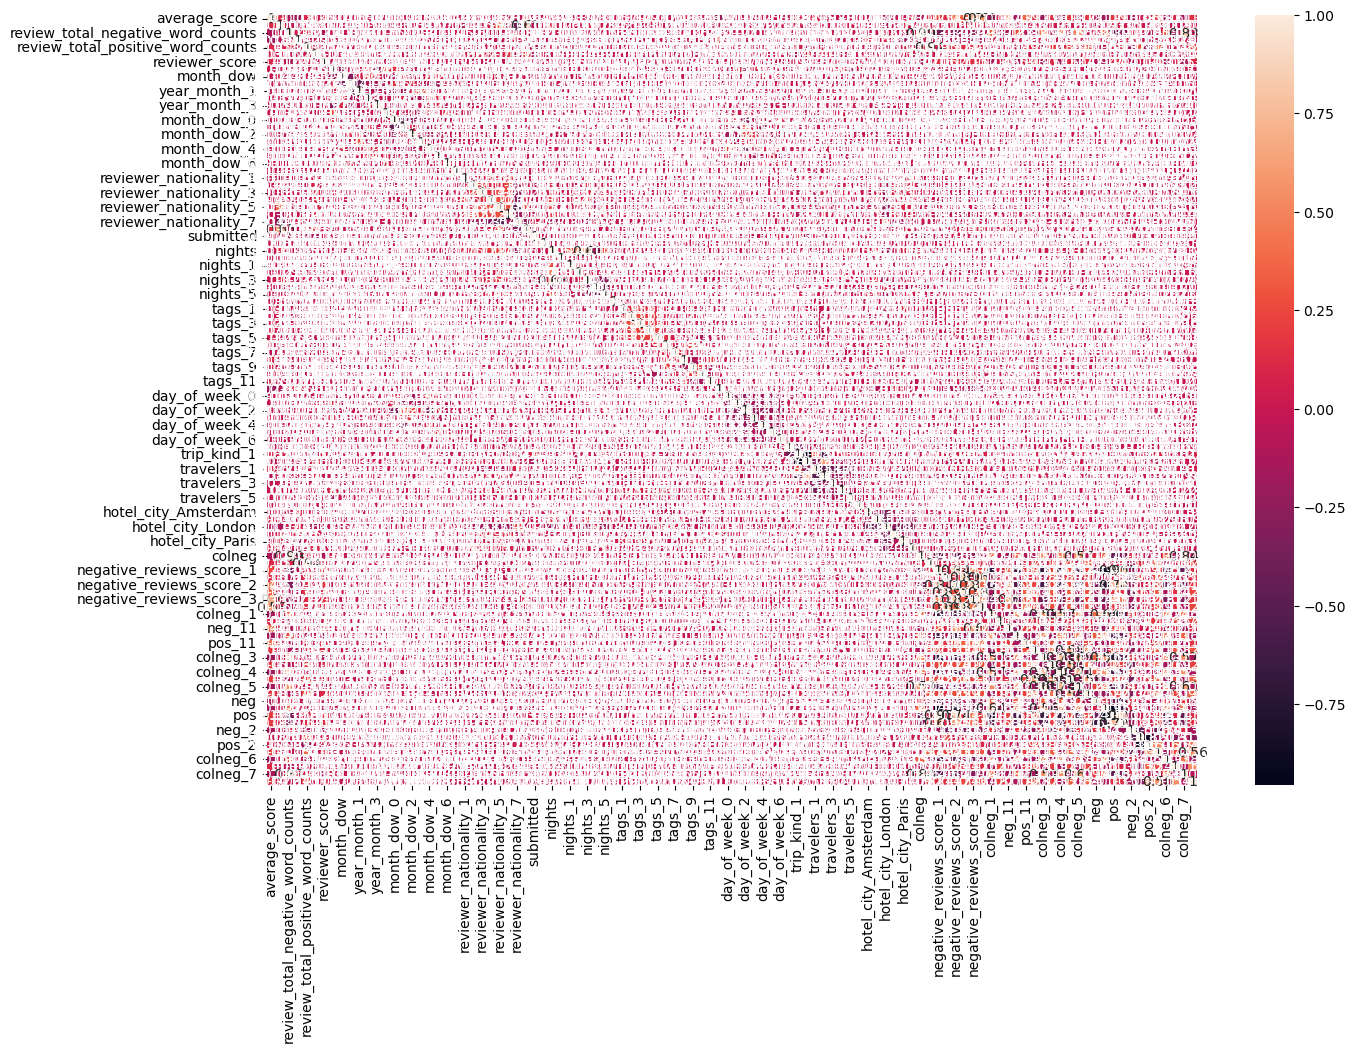

In [112]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [113]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [114]:
%%time
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  7.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


MAPE: 0.10947104761573216
CPU times: user 31min 6s, sys: 5.13 s, total: 31min 11s
Wall time: 7min 59s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


<AxesSubplot:>

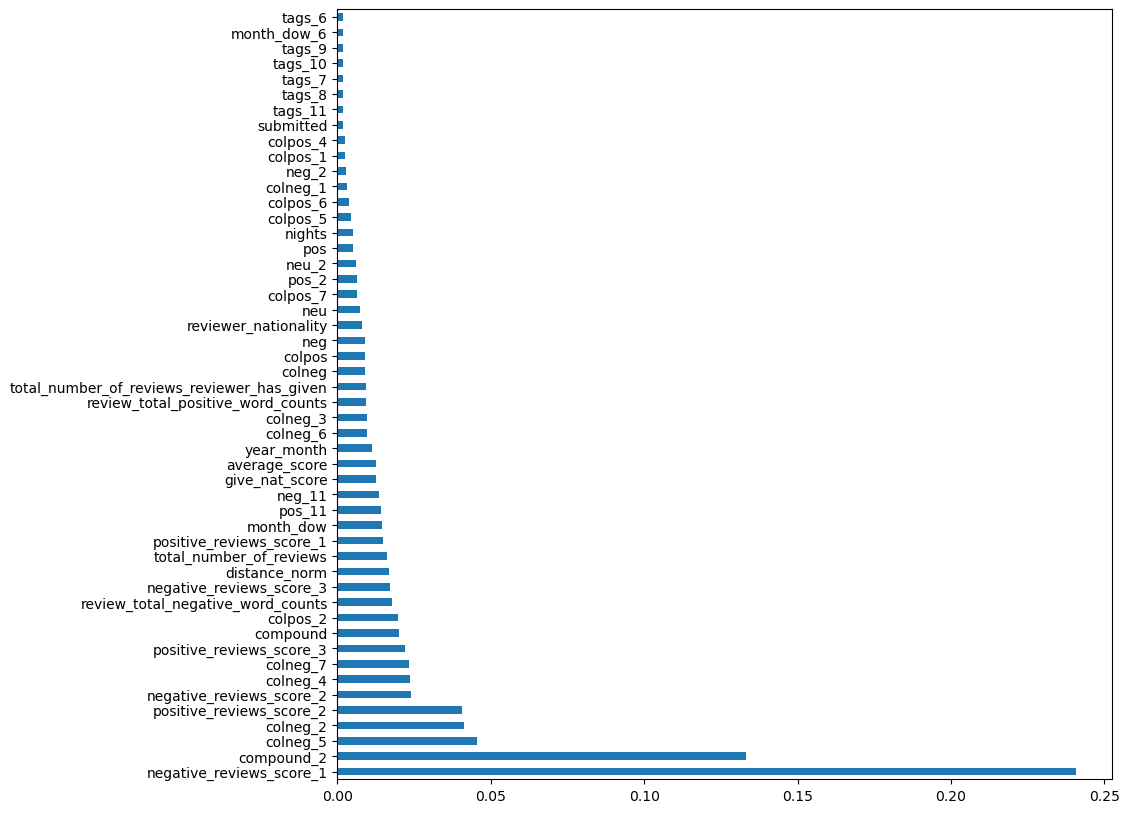

In [115]:
## в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(50).plot(kind='barh')

In [116]:
test_data.sample(10)

average_score  reviewer_nationality  review_total_negative_word_counts  \
36564            8.1              8.387927                                106   
30859            8.6              8.405097                                 15   
13838            7.5              8.364623                                 28   
24541            8.6              8.453597                                 61   
93               7.8              8.368664                                 18   
72760            8.6              8.387927                                  7   
14607            8.5              8.380912                                300   
8898             7.7              8.401227                                 40   
61842            8.4              8.387927                                  0   
34139            8.8              8.470942                                  0   

       total_number_of_reviews  review_total_positive_word_counts  \
36564                     9568                                  0   
30859                     1686                                  0   
13838                     5180                                  3   
24541                     4530                                  0   
93                         388                                  6   
72760                     3643                                  2   
14607                     3442                                 13   
8898                      4380                                  0   
61842                      845                                 29   
34139                      267                                 12   

       total_number_of_reviews_reviewer_has_given  reviewer_score  year_month  \
36564                                           2             0.0          20   
30859                                           2             0.0          10   
13838                                           4             0.0          23   
24541                                          14             0.0           8   
93                                             14             0.0          14   
72760                                           1             0.0          24   
14607                                          11             0.0          19   
8898                                           10             0.0           8   
61842                                           1             0.0          23   
34139                                           4             0.0          28   

       month_dow  year_month_0  ...    pos  compound  neg_2  neu_2  pos_2  \
36564         51             0  ...  0.222    0.9686  0.379  0.000  0.621   
30859         69             0  ...  0.000    0.0000  0.379  0.000  0.621   
13838         73             1  ...  0.091   -0.6542  0.000  0.377  0.623   
24541         53             0  ...  0.063    0.4289  0.379  0.000  0.621   
93             9             1  ...  0.000   -0.2247  0.000  0.549  0.451   
72760         83             0  ...  0.000   -0.1779  0.000  0.263  0.737   
14607         44             1  ...  0.140    0.9636  0.000  0.753  0.247   
8898          49             0  ...  0.043   -0.2751  0.379  0.000  0.621   
61842         71             1  ...  1.000    0.5574  0.000  0.653  0.347   
34139         24             0  ...  1.000    0.5574  0.000  0.730  0.270   

       compound_2  colneg_6  colpos_6  colneg_7  colpos_7  
36564      0.3400         7        46        31        47  
30859      0.3400        67        46        15        47  
13838      0.5106        31         4        31         3  
24541      0.3400         7        46        31        47  
93         0.6249        18        46        18        47  
72760      0.4215        31        21        31         2  
14607      0.5574        31        46        67        47  
8898       0.3400         7        46        40        47  
61842      0.9225         0        46         0        47  
34139      0.57

In [117]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [118]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [119]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.8s finished


In [120]:
predict_submission

array([8.71 , 7.291, 9.033, ..., 8.736, 9.4  , 6.59 ])

In [121]:
list(sample_submission)

['reviewer_score', 'id']

In [122]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.710  488440
1           7.291  274649
2           9.033  374688
3           9.759  404352
4           9.528  451596
5           8.275  302161
6           7.639  317079
7           7.675   13963
8           8.170  159785
9           6.377  195089